# **Imports**

In [ ]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functionsML as f
from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler

# data partition
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import importlib
importlib.reload(f)

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


### **Import data sets**

In [32]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Data exploration**

Our goal here is to understand the data, and the issues that come with it

- Typos in transmission and fuel

- EngineSize with NaN

- Mileage, mpg and previousOwners with irational values

- PreviousOwners with negative values

- hasDamage seems to always be 0

- The categorical variables have a lot of unique values

- Missing values in year mileage tax mpg engineSize paintQuality% previousOwners and hasDamage

- Alarming min values in mileage tax mpg engineSize paintQuality% previousOwners

- Alarming max values in year mpg paintQuality% previousOwners

- HasDamage is always 0

- Year is float64, should be int64

- PreviousOwners is float, should be int64

# **Unique Values**

We wanted to take a better look at what kind of values each variable had, and we ended up finding:

- Typos in every categorical variable

- Different letter casing in every categorical variable

- Unrealistic negative values and irrational values in every numerical category

- There is a strong correlation between mpg's and tax's missing values

# **Distributions & Value Counts**

#### Here we aim to treat the spotted issues, treat outliers and NaN values

In [33]:
# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
train_db_categorical = train_db.select_dtypes(include=["object"]).columns
train_db[train_db_categorical] = train_db[train_db_categorical].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db_categorical:
    train_db = f.fix_typos(col, train_db)

# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Rounds every other irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

### **Outlier treatment**

- We can imideatly spot some issues on the graphs, including absurd values and values that don't make sense

In [34]:
# Removed replace absurd/incorrect values with NaN for them later to be filled
train_db.loc[train_db["mileage"] < 0, "mileage"] = np.nan
train_db.loc[~train_db["tax"].between(0, 400), "tax"] = np.nan
train_db.loc[~train_db["mpg"].between(0, 150), "mpg"] = np.nan
train_db.loc[~train_db["engineSize"].between(1, 6), "engineSize"] = np.nan
train_db.loc[train_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
train_db.loc[~train_db["year"].between(1990, 2020), "year"] = np.nan
train_db.loc[~train_db["previousOwners"].between(0, 4), "previousOwners"] = np.nan


#### Next we apply log(1 + x) transformation to reduce skewness and normalize distribution
#### This will help our model handle right-skewed variables better
#### We will also aplly a clipping cap to the tax's and enfineSize's 1% and 99% in order to reduce the effects of the outliers on the final outcome

In [35]:
train_db['price'] = np.log1p(train_db['price'])
train_db['mileage'] = np.log1p(train_db['mileage'])
train_db['mpg'] = np.log1p(train_db['mpg'])

# Identify lower and upper bounds for the 'tax' feature at the 1st and 99th percentiles
# This is used to remove extreme outliers that could distort the model
tax_lower, tax_upper = train_db['tax'].quantile([0.01, 0.99])

# Clip (cap) 'tax' values to the 1%–99% range to limit outlier influence
train_db['tax'] = train_db['tax'].clip(tax_lower, tax_upper)

# Apply log(1 + x) transformation to 'tax' for normalization
train_db['tax'] = np.log1p(train_db['tax'])

# Do the same outlier clipping process for the 'engineSize' feature
engineSize_lower, engineSize_upper = train_db['engineSize'].quantile([0.01, 0.99])
train_db['engineSize'] = train_db['engineSize'].clip(engineSize_lower, engineSize_upper)


## **Variable Relationships**

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [36]:
cat_cols = train_db.select_dtypes(include=['object']).columns

# Compute Cramér's V between all pairs
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = f.cramers_v(train_db[col1], train_db[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")

Cramér's V between Brand and model: 0.995
Cramér's V between Brand and transmission: 0.299
Cramér's V between Brand and fuelType: 0.278
Cramér's V between model and transmission: 0.363
Cramér's V between model and fuelType: 0.489
Cramér's V between transmission and fuelType: 0.199


So we ended up going with a Theil's U directional relationship, while also testing out different variable combinations

In [37]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [8]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.579
 ('mileage', 'fuelType') => 0.511
 ('mileage', 'Brand') => 0.507

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'model') => 0.492
 ('year', 'Brand') => 0.456
 ('year', 'fuelType') => 0.454

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.469
 ('mpg', 'model') => 0.438
 ('mpg', 'Brand') => 0.361

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.556
 ('tax', 'model') => 0.489
 ('engineSize', 'model') => 0.463

For numerical column 'engineSize', top helpers (R² or η²):
 ('mpg', 'model') => 0.787
 ('tax', 'model') => 0.737
 ('model', 'fuelType') => 0.726

For numerical column 'paintQuality%', top helpers (R² or η²):
 ('mileage', 'model') => 0.021
 ('year', 'model') => 0.015
 ('previousOwners', 'model') => 0.011

For numerical column 'previousOwners', top helpers (R² or η²):
 ('paintQuality%', 'model') => 0.024
 ('mileage', 'mode

## **Filling in missing values**

In [9]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["paintQuality%"] = train_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


- Now no variable has missing values

# **Feature Selection**

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

We need to encode categorical variables into numericals, and we decided to encode Brand transmission and fuelType with one-hot encoding, and we also created a Brand_model_encoded where, using kfold traget encode, we can achieve a numerical model without having to worry about different brands having models with the same name

In [10]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

We split the dataframe into two groups, one to train the model, and the other to validate it

In [11]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

X has the numeric variables extracted and scaled

In [12]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

In [13]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
49782,0.833333,0.771881,0.533617,0.789973,0.00,0.363450,0.25,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.460868
72756,0.791667,0.833015,0.890623,0.722420,0.20,0.609856,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.390708
14648,0.833333,0.799564,0.890623,0.718810,0.50,0.815195,0.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.549204
65927,0.958333,0.723917,0.873482,0.780581,0.30,0.527721,0.25,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.511118
22160,0.958333,0.704811,0.873482,0.789973,0.00,0.804928,0.50,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.462162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21265,0.625000,0.893916,0.873482,0.766597,0.50,0.445585,0.50,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573826
45954,0.958333,0.690935,0.879384,0.789973,0.00,0.353183,1.00,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.460087
42670,0.625000,0.671780,0.873482,0.729973,0.25,0.897331,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.584011
43625,0.958333,0.649454,0.873482,0.726479,0.50,0.661191,0.75,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546122


Checking the categorical variables correlation with the target

In [14]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.569)
model is IMPORTANT for prediction (η = 0.755)
transmission is IMPORTANT for prediction (η = 0.567)
fuelType is IMPORTANT for prediction (η = 0.254)


Calculated the optimal number of features for a Linear Regression

In [15]:
#no of features
nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on validation data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 19
Score with 19 features: 0.894657


In [16]:
model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 19)

train_db_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

rfe.support_

array([ True,  True, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [17]:
X_train_num_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 'skoda',
       'toyota', 'vw', 'manual', 'semi-auto', 'unknown', 'electric', 'hybrid',
       'petrol', 'Brand_model_encoded'],
      dtype='object')

In [18]:
rfe.ranking_

array([1, 1, 2, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

year                    True
mileage                 True
tax                    False
mpg                     True
engineSize              True
paintQuality%          False
previousOwners         False
bmw                     True
ford                    True
hyundai                 True
mercedes                True
opel                    True
skoda                   True
toyota                  True
vw                      True
manual                  True
semi-auto               True
unknown                 True
electric                True
hybrid                  True
petrol                  True
Brand_model_encoded     True
dtype: bool

Check the feature importance with the LassoCV

In [20]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 21 variables and eliminated the other 1 variables


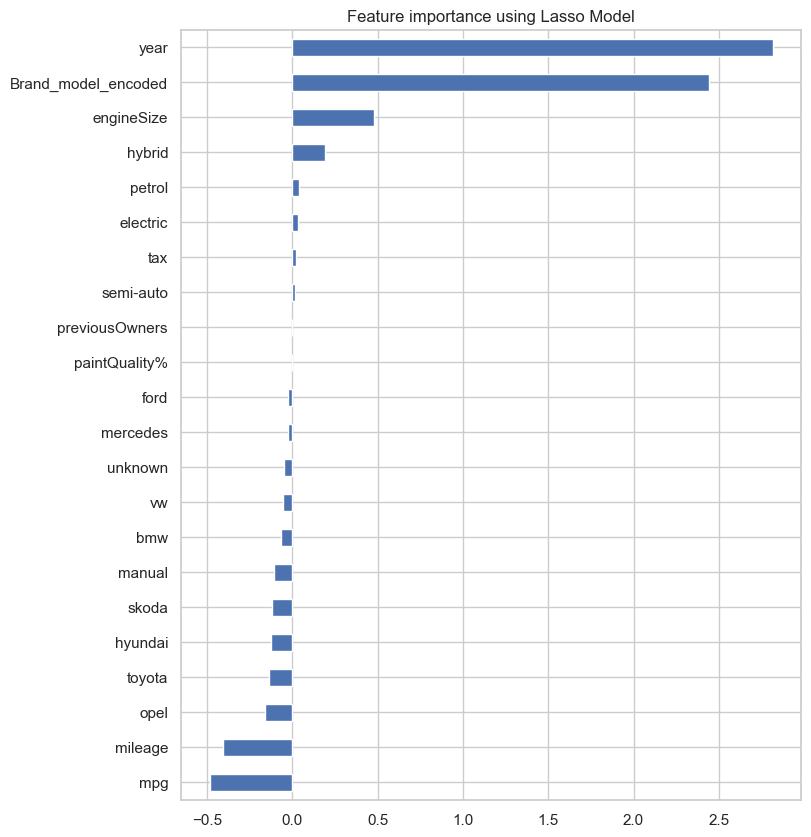

In [21]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | RFE LR| Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |---|
| year | Keep? | Keep | Keep | Include in the model |
| engineSize | Keep | Keep |Keep| Include in the model |
| tax | Keep?| Discard? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard | Discard |
| paintQuality% | Keep? | Discard | Discard | Discard |
| mpg | Keep? | Keep | Keep? | Try with and without |
| mileage | Keep? | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>



After testing out different combinations, we came to the conclusion that dropping previousOwners and paintQuality% had the best return

In [22]:
X_train_num_scaled = X_train_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

X_val_num_scaled = X_val_num_scaled.drop(columns=['previousOwners', "paintQuality%"])

perguntar ao professor mesmo se knn nao se pode usar as variaveis categoricas emsmo depois de transformadas em numericas, porque da melhor resultado no entanto o chat gpt diz que nao se deva variaveis categoricas mesmo depois ... antes estava r2 0.93 e depois 0.85

Tipo de dado         	Métrica recomendada
Numérico contínuo,escalado	                  euclidean ou minkowski (p=2)
Numérico com outliers	                      manhattan ou chebyshev
Dados normalizados entre 0 e 1	                euclidean ou cosine
Dados correlacionados ou com escalas diferentes	                  mahalanobis
Alta dimensionalidade, direção importa (ex: embeddings)	            cosine

In [23]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


X_train_num_scaled_import = X_train_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
X_val_num_scaled_import   = X_val_num_scaled[['year', 'mileage', 'tax', 'mpg', 'engineSize']]


# 1. Definir o Modelo KNN
# Começamos com um k=5 padrão, mas isso pode ser otimizado
knn_model = KNeighborsRegressor(n_neighbors=10, metric='manhattan', n_jobs=-1)

# 2. Treinar o Modelo
# Nota: Usamos os dados ESCALONADOS (scaled), isso é obrigatório para o KNN
knn_model.fit(X_train_num_scaled_import, y_train)

# 3. Prever nos dados de validação
y_pred_knn = knn_model.predict(X_val_num_scaled_import)

# 4. Avaliar o Modelo
print("--- Resultados Iniciais do KNN (k=5) ---")
print(f"R²: {r2_score(y_val, y_pred_knn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_knn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_knn)):.2f}")




--- Resultados Iniciais do KNN (k=5) ---
R²: 0.864
MAE: 0.14
RMSE: 0.20


In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV # Importação alterada
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from scipy.stats import randint # Útil para definir intervalos de números inteiros aleatórios

# 1. Definir o modelo
knn = KNeighborsRegressor(n_jobs=-1)

# 2. Definir a distribuição dos parâmetros
# No RandomizedSearch, para valores numéricos, usamos distribuições (como randint)
# ou listas. Ele vai "sortear" valores daqui.
param_dist = {
    'n_neighbors': randint(1, 31),  # Sorteia valores inteiros entre 1 e 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# 3. Configurar a busca (Randomized Search)
# n_iter=20: Define que vamos testar apenas 20 combinações aleatórias (mais rápido que o Grid)
random_search = RandomizedSearchCV(
    estimator=knn, 
    param_distributions=param_dist, 
    n_iter=20, # Número de iterações (combinações aleatórias) a testar
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    random_state=42 # Garante que os sorteios sejam reproduzíveis
)

# 4. Treinar
print("Procurando os melhores hiperparâmetros (Random Search)...")
random_search.fit(X_train_num_scaled_import, y_train)

# 5. Resultados
best_model = random_search.best_estimator_
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")

# 6. Avaliação Final na Validação
pred = best_model.predict(X_val_num_scaled_import)
rmse = np.sqrt(mean_squared_error(y_val, pred))

print("-" * 30)
print(f"R²: {r2_score(y_val, pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, pred):.2f}")
print(f"RMSE: {rmse:.2f}")

Procurando os melhores hiperparâmetros (Random Search)...
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
------------------------------
R²: 0.865
MAE: 0.14
RMSE: 0.20


In [30]:
# --- 1. Limpeza e Pré-processamento Inicial ---
# (Idêntico ao pipeline anterior, garantindo consistência)

# Carregar dataset de teste
test_db = pd.read_csv("test.csv")
test_db = test_db.drop(columns="hasDamage", errors='ignore')

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Corrigir gralhas
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Tratamento de valores negativos/irracionais
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Converter para inteiros nullable
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# --- 2. Transformações Numéricas (Essencial para KNN - Distâncias) ---

test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Usar os limites do treino (tax_lower, tax_upper) se existirem
if 'tax_lower' in locals():
    test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

if 'engineSize_lower' in locals():
    test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# --- 3. Imputação de Valores em Falta ---

test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Preencher residuais com médias de grupo ou globais
numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')
for col in numeric_cols:
    test_db[col] = test_db[col].astype(float)
    category_means = test_db.groupby("model")[col].transform('median')
    test_db[col] = test_db[col].fillna(category_means)
    global_mean = test_db[col].median()
    test_db[col] = test_db[col].fillna(global_mean)
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")

# --- 4. Encoding e Escalonamento ---

# One-hot encode (necessário para manter consistência das colunas, mesmo que não usemos no KNN final)
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)

# Selecionar colunas numéricas
X_test_num = test_db.select_dtypes(include=np.number).set_index(test_db.index)
X_test_num = X_test_num.drop(columns=["carID", "price"], errors='ignore')

# Alinhar colunas com o treino (X_train_num deve estar em memória)
X_test_num = X_test_num.reindex(columns=X_train_num.columns, fill_value=0)

# Escalonamento (Obrigatório para KNN)
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# --- 5. Seleção de Features Específica do KNN ---
# No notebook (Célula 23/24), o KNN foi treinado apenas com estas 5 colunas.
# Temos de filtrar o dataset de teste para ter as mesmas colunas.

knn_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
X_test_knn = X_test_num_scaled[knn_features]

# --- 6. Previsão com KNN ---

if 'best_model' in locals():
    print(f"A usar o melhor modelo KNN do GridSearch com parâmetros: {best_model.get_params()}")
    model_to_use = best_model
elif 'knn_model' in locals():
    print("A usar o modelo KNN base (knn_model)...")
    model_to_use = knn_model
else:
    raise ValueError("Nenhum modelo KNN treinado encontrado (best_model ou knn_model). Execute a célula de treino do KNN primeiro.")

# Prever
y_test_pred = model_to_use.predict(X_test_knn)

# Inverter Log (np.log1p -> np.expm1)
test_db['price'] = np.expm1(y_test_pred)

# --- 7. Submissão ---

submission = test_db[['carID', 'price']].copy()
submission.to_csv("submission_knn.csv", index=False)
print("Ficheiro 'submission_knn.csv' criado com sucesso.")

A usar o melhor modelo KNN do GridSearch com parâmetros: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 29, 'p': 2, 'weights': 'distance'}
Ficheiro 'submission_knn.csv' criado com sucesso.


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Definir a Arquitetura da Rede
# Input shape é o número de colunas (features) que temos
input_shape = [X_train_num_scaled.shape[1]]

model = keras.Sequential([
    # Primeira camada oculta com 64 neurónios e ativação ReLU
    layers.Dense(64, activation='relu', input_shape=input_shape),
    # Dropout ajuda a prevenir overfitting desligando 20% dos neurónios aleatoriamente
    layers.Dropout(0.2),
    
    # Segunda camada oculta
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    
    # Terceira camada oculta (opcional, para mais complexidade)
    layers.Dense(16, activation='relu'),
    
    # Camada de Saída: 1 único neurónio para prever o preço (valor contínuo)
    layers.Dense(1)
])

# 2. Compilar o Modelo
# 'adam' é um otimizador excelente e versátil
# 'mae' (Mean Absolute Error) é uma boa métrica de perda para preços
model.compile(
    optimizer='adam',
    loss='mean_squared_error', # Usamos MSE para guiar o treino (penaliza grandes erros)
    metrics=['mae']
)

# 3. Configurar Paragem Antecipada (Early Stopping)
# Se o modelo parar de melhorar na validação, paramos o treino para não decorar os dados
early_stopping = EarlyStopping(
    min_delta=0.001, # Mínima melhoria considerada
    patience=10,     # Quantas épocas esperar sem melhoria antes de parar
    restore_best_weights=True
)

# 4. Treinar a Rede
print("A treinar a Rede Neuronal...")
history = model.fit(
    X_train_num_scaled, y_train,
    validation_data=(X_val_num_scaled, y_val),
    batch_size=32, # Quantos carros analisa de cada vez antes de atualizar pesos
    epochs=100,    # Máximo de passagens pelos dados
    callbacks=[early_stopping],
    verbose=1 # Mostra a barra de progresso
)

# 5. Avaliar o Desempenho
y_pred_nn = model.predict(X_val_num_scaled)

print("\n--- Resultados da Rede Neuronal ---")
print(f"R²: {r2_score(y_val, y_pred_nn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_nn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")

# 6. Gráfico de Aprendizagem (Loss Curve)
# Isto mostra se o modelo estava a aprender bem ou a decorar (overfitting)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Treino (Loss)')
plt.plot(history.history['val_loss'], label='Validação (Loss)')
plt.title('Curva de Aprendizagem')
plt.xlabel('Épocas')
plt.ylabel('Erro (MSE)')
plt.legend()
plt.grid(True)
plt.show()

A treinar a Rede Neuronal...
Epoch 1/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.6189 - mae: 1.2183 - val_loss: 0.3760 - val_mae: 0.5767
Epoch 2/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6064 - mae: 0.6037 - val_loss: 1.5333 - val_mae: 1.1983
Epoch 3/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2561 - mae: 0.3833 - val_loss: 0.5591 - val_mae: 0.6964
Epoch 4/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1295 - mae: 0.2692 - val_loss: 0.1890 - val_mae: 0.3864
Epoch 5/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0696 - mae: 0.1959 - val_loss: 0.1045 - val_mae: 0.2720
Epoch 6/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0487 - mae: 0.1643 - val_loss: 0.0710 - val_mae: 0.2152
Epoch 7/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0418 - mae: 0.1512 - val_loss: 0.1125 - val_mae: 0.2795
Epoch 8/100
1660/1660 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0383 - mae: 0.1443 - val_loss: 0.0446 - val_mae: 0.1617
Epo

KeyboardInterrupt: 

A treinar o MLPRegressor...
Iteration 1, loss = 4.79436540
Validation score: 0.391093
Iteration 2, loss = 0.03958401
Validation score: 0.846063
Iteration 3, loss = 0.02065649
Validation score: 0.865710
Iteration 4, loss = 0.01896261
Validation score: 0.869871
Iteration 5, loss = 0.01773485
Validation score: 0.882251
Iteration 6, loss = 0.01664553
Validation score: 0.888977
Iteration 7, loss = 0.01583338
Validation score: 0.892223
Iteration 8, loss = 0.01537948
Validation score: 0.896965
Iteration 9, loss = 0.01483318
Validation score: 0.898773
Iteration 10, loss = 0.01441154
Validation score: 0.901316
Iteration 11, loss = 0.01396108
Validation score: 0.900293
Iteration 12, loss = 0.01365883
Validation score: 0.905740
Iteration 13, loss = 0.01348084
Validation score: 0.900651
Iteration 14, loss = 0.01321872
Validation score: 0.905495
Iteration 15, loss = 0.01306151
Validation score: 0.910797
Iteration 16, loss = 0.01265766
Validation score: 0.909899
Iteration 17, loss = 0.01255323
Valid

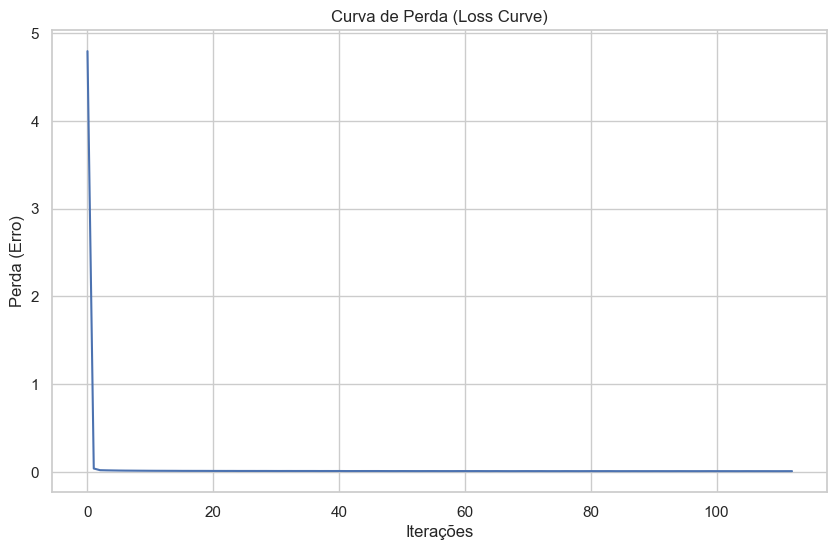


--- Resultados do MLPRegressor ---
R²: 0.932
MAE: 0.10
RMSE: 0.14


In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Definir a Rede Neuronal (MLPRegressor)
# De acordo com a aula, definimos as camadas ocultas. 
# Vamos tentar uma configuração "Média/Forte": 2 camadas com 100 e 50 neurónios.
# 'max_iter' define quantas vezes a rede vê os dados.
# 'early_stopping' pára o treino se não houver melhorias (evita overfitting).
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    early_stopping=True, 
    random_state=42,
    verbose=True # Para ver o progresso como no notebook da aula
)

# 2. Treinar o Modelo
print("A treinar o MLPRegressor...")
mlp_model.fit(X_train_num_scaled, y_train)

# 3. Visualizar a Curva de Aprendizagem (Igual à aula)
# Isto mostra como o erro diminuiu ao longo das iterações
plt.figure(figsize=(10, 6))
losses = mlp_model.loss_curve_
iterations = range(mlp_model.n_iter_)
sns.lineplot(x=iterations, y=losses)
plt.title('Curva de Perda (Loss Curve)')
plt.xlabel('Iterações')
plt.ylabel('Perda (Erro)')
plt.grid(True)
plt.show()

# 4. Avaliação
y_pred_mlp = mlp_model.predict(X_val_num_scaled)

print("\n--- Resultados do MLPRegressor ---")
print(f"R²: {r2_score(y_val, y_pred_mlp):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_mlp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_mlp)):.2f}")

eles disseram que nao posso ir ja com os dados tratados nao posso fazer holdout ( que aquilo que nos fazemos (separamos os dados em validacao e treino)) e depois cross validation que é o que esta no random search , posso faZER holdout mas tenho depois juntar e indicar 0 num grupo e -1 noutro e depois introduzir esse dataset no random search ou netao meter os dados cru e depois fazer pipeline ,,, treshold variaveis que tem menos do que aquela variancia vao embora porque os que nao tem variancia nao interessam,,,,,   

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import uniform, randint # Necessário para distribuições aleatórias

# 1. Definir a Grelha para Random Search
# No Random Search, podemos usar distribuições (ex: uniform) em vez de listas fixas
param_dist = {
    # Arquitetura: Testamos desde redes simples até muito profundas/largas
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)  ###incluir sempre os defaults
    ],
    
    # Ativação: A Tanh por vezes lida melhor com regressão do que a ReLU
    'activation': ['relu', 'tanh', 'logistic'],
    
    # Solver: O SGD é clássico, Adam é moderno, LBFGS é bom para dados pequenos
    'solver': ['adam', 'sgd', 'lbfgs'],
    
    # Alpha (Regularização): Usamos uma distribuição contínua para testar valores muito finos
    'alpha': uniform(0.0001, 0.05), # Testa qualquer valor entre 0.0001 e 0.05
    
    'batch_size': [32, 64, 'auto'],
    # Learning Rate: Importante para o SGD
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    
    
    # Early Stopping: Ativar para evitar overfitting
    'early_stopping': [True],
    #como tenho early stopping 
    # Validation Fraction: Quanto dos dados de treino usar para parar cedo (se early_stopping=True)
    'validation_fraction': [0.1, 0.2]
}

# 2. Configurar o Modelo Base
mlp = MLPRegressor(max_iter=1000, random_state=42) # 2000 iterações para dar tempo ao SGD

# 3. Configurar a Busca Aleatória (Random Search)
# n_iter=50 significa que vamos testar 50 combinações aleatórias diferentes
random_search = RandomizedSearchCV(
    mlp, 
    param_distributions=param_dist, 
    n_iter=50,      # Aumente para 100 se tiver tempo (melhor resultado)
    cv=3,           # Validação cruzada de 3 folds
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,      # Usa todos os cores do CPU
    verbose=1,
    random_state=42
)

print("A executar Randomized Search (a testar 50 combinações complexas)...")
random_search.fit(X_train_num_scaled, y_train)

# 4. Melhores Resultados
best_nn = random_search.best_estimator_
print(f"\nMelhores Parâmetros Encontrados:\n{random_search.best_params_}")

# 5. Gráfico da Curva de Aprendizagem (Loss Curve)
# Nota: LBFGS não suporta loss_curve_ nem early_stopping da mesma forma
if best_nn.solver != 'lbfgs':
    plt.figure(figsize=(10, 6))
    plt.plot(best_nn.loss_curve_, label='Training Loss')
    # Se early_stopping foi usado efetivamente, podemos ter validation scores
    if hasattr(best_nn, 'validation_scores_') and best_nn.validation_scores_ is not None:
        plt.plot(best_nn.validation_scores_, label='Validation Score (Accuracy/R2 proxy)')
        
    plt.title(f'Evolução do Treino - Solver: {best_nn.solver} | Ativação: {best_nn.activation}')
    plt.xlabel('Iterações')
    plt.ylabel('Loss / Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"A rede parou após {best_nn.n_iter_} iterações.")
else:
    print(f"O solver vencedor foi '{best_nn.solver}' (Otimizador analítico - sem gráfico de evolução iterativa).")

# 6. Avaliação Final nos Dados de Validação
y_pred_nn = best_nn.predict(X_val_num_scaled)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("\n--- Performance Final (Random Search) ---")
print(f"R²: {r2_score(y_val, y_pred_nn):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_nn):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_nn)):.2f}")

A executar Randomized Search (a testar 50 combinações complexas)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Melhores Parâmetros Encontrados:
{'activation': 'relu', 'alpha': np.float64(0.003344612355449078), 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (200, 100), 'learning_rate': 'adaptive', 'solver': 'lbfgs', 'validation_fraction': 0.2}
O solver vencedor foi 'lbfgs' (Otimizador analítico - sem gráfico de evolução iterativa).

--- Performance Final (Random Search) ---
R²: 0.935
MAE: 0.10
RMSE: 0.14


In [29]:
# --- 1. Limpeza e Pré-processamento Inicial ---
# (Mantém-se a lógica original, mas adicionamos as transformações numéricas críticas)

# Drop irrelevant column
test_db = pd.read_csv("test.csv") # Garantir que carrega o ficheiro original
test_db = test_db.drop(columns="hasDamage", errors='ignore')

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Tratamento de valores negativos/irracionais
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Safely convert to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# --- 2. Transformações Numéricas (CRÍTICO para Redes Neuronais) ---
# Aplicar as mesmas transformações log e clip que fez no treino (Célula 5)

test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Usar os limites calculados no treino (tax_lower, tax_upper, etc.)
# Se as variáveis não estiverem em memória, defina valores aproximados ou recalcule
if 'tax_lower' in locals():
    test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

if 'engineSize_lower' in locals():
    test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# --- 3. Imputação de Valores em Falta ---

# Fill categorical columns
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# Fill remaining numeric
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Fill residual NaNs with group means
numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')
for col in numeric_cols:
    test_db[col] = test_db[col].astype(float)
    category_means = test_db.groupby("model")[col].transform('median')
    test_db[col] = test_db[col].fillna(category_means)
    global_mean = test_db[col].median() # Usar median é mais robusto
    test_db[col] = test_db[col].fillna(global_mean)
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")

# --- 4. Encoding e Alinhamento de Colunas ---

# One-hot encode
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)

# Target Encode Mapping (usando o dicionário criado no treino)
# Nota: 'mapping' e 'global_mean' devem vir do treino (Célula 10 ou similar)
if 'mapping' not in locals():
    # Recriar mapping se necessário (apenas se ainda tiver o train_db carregado)
    mapping = train_db.set_index(["Brand", "model"])["Brand_model_encoded"].to_dict()
    global_mean_encoded = train_db["Brand_model_encoded"].median()
else:
    global_mean_encoded = global_mean # Assumindo que a variável do snippet anterior era global_mean

test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean_encoded), axis=1)
)

# --- 5. Preparação Final para a Rede Neuronal ---

# Selecionar apenas numéricas
X_test_num = test_db.select_dtypes(include=np.number).set_index(test_db.index)
X_test_num = X_test_num.drop(columns=["carID", "price"], errors='ignore')

# *** PASSO CRUCIAL: Alinhar colunas com o treino ***
# O get_dummies pode ter criado colunas diferentes. Temos de garantir que
# X_test_num tem exatamente as mesmas colunas e na mesma ordem que X_train_num
# (Preenche com 0 as colunas que faltam no teste mas existiam no treino)
X_test_num = X_test_num.reindex(columns=X_train_num.columns, fill_value=0)

# Escalonamento (usando o scaler treinado na Célula 13)
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

# Remover as colunas que decidimos não usar (Célula 22)
cols_to_drop = ['previousOwners', "paintQuality%"]
X_test_num_scaled = X_test_num_scaled.drop(columns=cols_to_drop, errors='ignore')

# --- 6. Previsão ---

# Escolha o seu melhor modelo. O 'best_nn' (do RandomizedSearch) ou 'mlp_model'.
# Vou usar 'best_nn' se existir, senão 'mlp_model', senão 'model' (keras).
if 'best_nn' in locals():
    model_to_use = best_nn
    print("A usar o modelo otimizado (best_nn)...")
elif 'mlp_model' in locals():
    model_to_use = mlp_model
    print("A usar o modelo MLP (mlp_model)...")
else:
    model_to_use = model # Keras model
    print("A usar o modelo Keras (model)...")

y_test_pred = model_to_use.predict(X_test_num_scaled)

# Se for modelo Keras, o output pode vir como [[p1], [p2]], precisamos de flatten
if len(y_test_pred.shape) > 1 and y_test_pred.shape[1] == 1:
    y_test_pred = y_test_pred.flatten()

# Inverter a transformação Log (np.log1p -> np.expm1)
# Isto é OBRIGATÓRIO porque treinámos o modelo com preços em log
test_db['price'] = np.expm1(y_test_pred)

# --- 7. Submissão ---

submission = test_db[['carID', 'price']].copy()
submission.to_csv("submission_neural_network.csv", index=False)
print("Ficheiro 'submission_neural_network.csv' criado com sucesso.")

A usar o modelo otimizado (best_nn)...
Ficheiro 'submission_neural_network.csv' criado com sucesso.


a partir de para baixo ja é do ricardo 

In [ ]:
# 3. Fit model
model = LinearRegression()
model.fit(X_train_num_scaled, y_train)

# 4. Predict
y_pred = model.predict(X_val_num_scaled)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")

R²: 0.895
MAE: 0.12
RMSE: 0.17


Now we apply all the methods we analysed to the Linear Regression model

In [ ]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)

# Apply the same filtering rules
test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
test_db.loc[~test_db["previousOwners"].between(0, 4), "previousOwners"] = np.nan



# Apply the same transformations
test_db['mileage'] = np.log1p(test_db['mileage'])
test_db['mpg'] = np.log1p(test_db['mpg'])

# Use the SAME clipping bounds from training data
test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
test_db['tax'] = np.log1p(test_db['tax'])

# Use the SAME clipping bounds from training data  
test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Remove paintQuality% above 100
test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")


# Fill numeric columns with median
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].mean()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from training data using both Brand and model
mapping = (
    train_db
    .set_index(["Brand", "model"])["Brand_model_encoded"]
    .to_dict()
)

# Compute global mean for unseen Brand-model pairs
global_mean = train_db["Brand_model_encoded"].median()

# Map test_df (Brand, model) pairs to encoded values
test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
)


# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

# Scale using the same scaler fitted on training data
X_test_num_scaled = scaler.transform(X_test_num)

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns).set_index(X_test.index)

X_test_num_scaled = X_test_num_scaled.drop(columns=[ 'previousOwners', "paintQuality%"])

In [ ]:
y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
test_db['price'] = np.expm1(y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)


# **Random Forest**

### **Import data sets**

In [2]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Fixing issues**

In [50]:
# Drop irrelevant column
train_db = train_db.drop(columns="hasDamage")

train_db_numerical = train_db.select_dtypes(exclude=["object"]).columns
# Lowercase text columns
train_db_categorical = train_db.select_dtypes(include=["object"]).columns
train_db[train_db_categorical] = train_db[train_db_categorical].apply(lambda x: x.str.lower() if x.dtype=="object" else x)


# Loop and fix all categorical columns
for col in train_db_categorical:
    train_db = f.fix_typos(col, train_db)

# Rounding future Int values
train_db.loc[:, "year"] = train_db["year"].round()

# Rounds every other irrational number into having one precision digit
for col in train_db.select_dtypes(include="float64").columns:
    # Round each column to 1 digit after the decimal
    train_db[col] = train_db[col].round(1)

### **Outlier treatment**

Since we are using Random Forest here, after some tests, we concluded that it is best to leave every value in, even if absurd

## **Variable Relationships**

This segment follow the same exact logic as the linear regression

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

In [51]:
num_cols = train_db.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns


# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_db[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_db[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:



For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.562
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.519

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.326
  U(transmission | model + fuelType) = 0.316
  U(transmission | Brand + model) = 0.291

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.403
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [52]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_db[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_pair in combinations(cat_cols, num_paired):
            combined = train_db[list(cat_pair)].astype(str).agg('_'.join, axis=1)
            scores[cat_pair] = f.correlation_ratio(combined, train_db[target]) ** 2


    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_db[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=15, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")



For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.546
 ('tax', 'model') => 0.487
 ('mileage', 'fuelType') => 0.470

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'engineSize') => 0.457
 ('year', 'model') => 0.455
 ('year', 'previousOwners') => 0.451

For numerical column 'tax', top helpers (R² or η²):
 ('year', 'model') => 0.471
 ('mpg', 'model') => 0.384
 ('mileage', 'model') => 0.341

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.667
 ('engineSize', 'fuelType') => 0.497
 ('engineSize', 'model') => 0.438

For numerical column 'engineSize', top helpers (R² or η²):
 ('tax', 'model') => 0.696
 ('mpg', 'model') => 0.678
 ('model', 'fuelType') => 0.663

For numerical column 'paintQuality%', top helpers (R² or η²):
 ('previousOwners', 'model') => 0.013
 ('tax', 'model') => 0.012
 ('mileage', 'model') => 0.012

For numerical column 'previousOwners', top helpers (R² or η²):
 ('paintQuality%', 'model') => 0.02

## **Filling in missing values**

In [53]:
# Safely convert previousOwners and year to nullable integers
train_db["previousOwners"] = pd.to_numeric(train_db["previousOwners"], errors='coerce').round().astype("Int64")
train_db["year"] = pd.to_numeric(train_db["year"], errors='coerce').round().astype("Int64")

# Handle Brand for i3
idx_to_drop = train_db[(train_db['model'] == 'i3') & (train_db['Brand'].isna())].index
train_db = train_db.drop(idx_to_drop)

# Fill categorical columns
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission","fuelType"])
train_db = f.fill_NaN_with_categorical(train_db, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_db = f.fill_NaN_with_categorical(train_db, "mpg", ["model","fuelType"])
train_db["transmission"] = train_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_db["fuelType"] = train_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
train_db = f.fill_NaN_with_mixed(train_db, "year", "model", "mileage")
train_db = f.fill_NaN_with_mixed(train_db, "mileage", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "tax", "model", "year")
train_db = f.fill_NaN_with_mixed(train_db, "engineSize", "model", "tax")

# Fill numeric columns with median
train_db["paintQuality%"] = train_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
train_db["previousOwners"] = train_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# Drop any remaining NaNs
train_db = train_db.dropna()


# **Feature Selection**

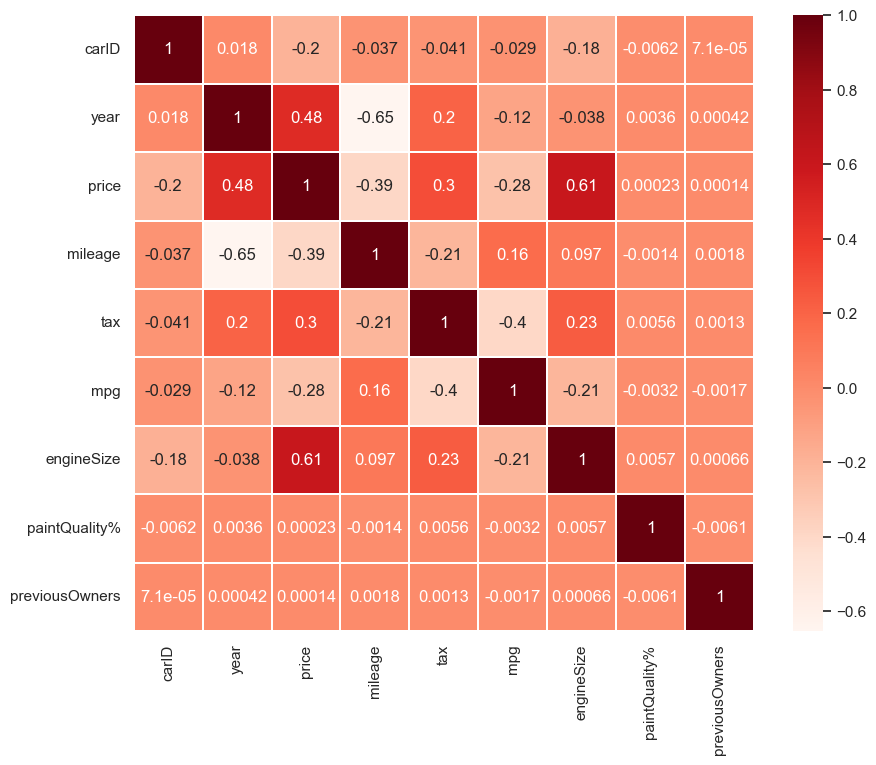

In [54]:
# Remove rows with missing values
temp = train_db.dropna()

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = corr_data.corr(method="pearson")

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

- year and mileage have a strong relationship
- and so does tax and pmg
- both paintQuality% and previousOwners seem to have little correlation with every variable

In [55]:
one_hot = pd.get_dummies(train_db["Brand"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot], axis=1)

train_db['transmission'] = train_db['transmission'].replace('other', 'unknown')

one_hot2 = pd.get_dummies(train_db["transmission"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot2], axis=1)

train_db["fuelType"] = train_db["fuelType"].replace('other', 'electric')

one_hot3 = pd.get_dummies(train_db["fuelType"], drop_first=True).astype(int)

train_db = pd.concat([train_db, one_hot3], axis=1)

train_db = f.kfold_target_encode(train_db, cat_cols=['Brand','model'], target_col='price', n_splits=5)

In [56]:
X = train_db.drop(columns=["price","carID"])
y = train_db["price"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, 
                                                  random_state = 0, 
                                                  shuffle = True)

In [57]:
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)

X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)

# repeat for val

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)


In [58]:
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)


#show results
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,bmw,ford,hyundai,...,skoda,toyota,vw,manual,semi-auto,unknown,electric,hybrid,petrol,Brand_model_encoded
9755,0.833333,0.253694,0.322009,0.194282,0.328358,0.446774,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.273483
7670,0.907407,0.159403,0.351810,0.177557,0.164179,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.160889
27365,0.870370,0.179484,0.351810,0.173084,0.238806,0.503226,0.500,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.124938
46630,0.925926,0.161295,0.351810,0.149747,0.462687,0.753226,0.750,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.271596
7887,0.907407,0.181495,0.351810,0.184364,0.223881,0.591935,0.250,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.078819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21245,0.870370,0.183523,0.180450,0.206534,0.313433,0.591935,0.500,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.098932
45900,0.888889,0.215811,0.351810,0.180863,0.313433,0.430645,0.625,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.140887
42619,0.870370,0.214196,0.351810,0.212174,0.253731,0.470968,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.087135
43574,0.870370,0.275482,0.180450,0.215286,0.313433,0.608065,0.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161609


In [59]:
for var in X_train_cat:
    f.TestCorrelationRatio(X_train_cat[var],y_train, var)

Brand is IMPORTANT for prediction (η = 0.537)
model is IMPORTANT for prediction (η = 0.761)
transmission is IMPORTANT for prediction (η = 0.542)
fuelType is IMPORTANT for prediction (η = 0.205)


In [60]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_num_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 22 variables and eliminated the other 0 variables


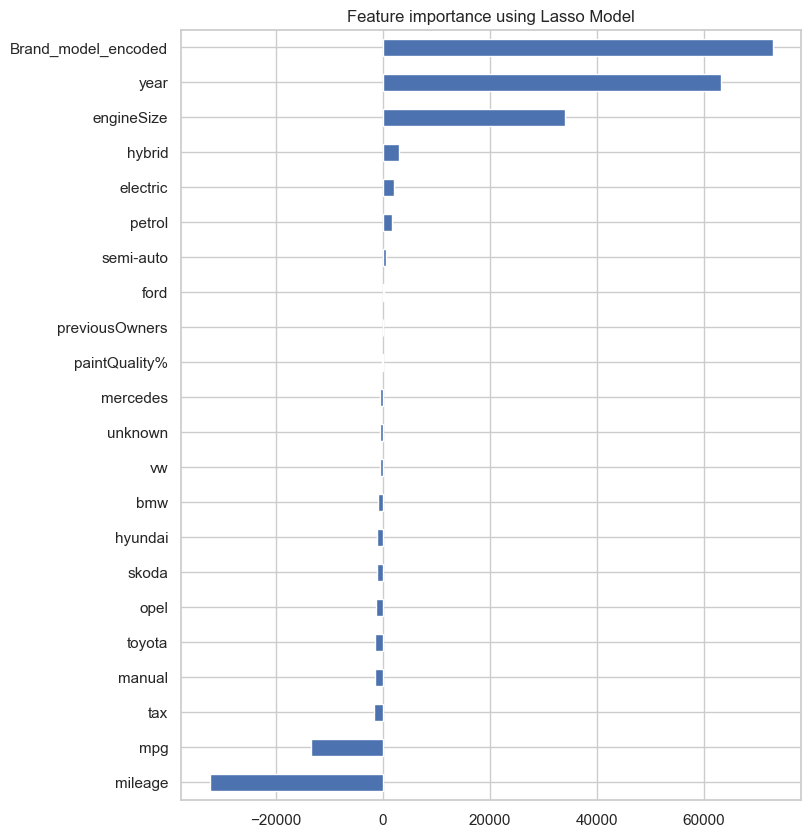

In [61]:
plot_importance(coef,'Lasso')

<hr>

### Numerical Data

| Predictor | Pearson | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |
| year | Keep? | Keep | Include in the model |
| engineSize | Keep |Keep| Include in the model |
| tax | Keep? | Discard | Try with and without |
| previousOwners | Keep? | Discard | Discard |
| paintQuality% | Keep? | Discard | Discard |
| mpg | Keep?  | Keep? | Try with and without |
| mileage | Keep | Keep | Keep |

<hr>


### Categorical Data

| Predictor | Correlation Ratio | 
| --- | --- | 
| Brand | Keep |  
|  model | Keep | 
| transmission | Keep |
| fuelType| Keep? |


<hr>




Even though we are using a random forest here, we still applied the same feature selection methods as in linear regression, and it ended up performing better than using all the features

In [62]:
X_train_num = X_train_num.drop(columns=['previousOwners', "paintQuality%"])

X_val_num = X_val_num.drop(columns=['previousOwners', "paintQuality%"])

The n_estimators was tested through trial and error

In [63]:
model = RandomForestRegressor(
    n_estimators=70,   # number of trees
    random_state=42,
    n_jobs=-1           
)
model.fit(X_train_num, y_train)

# 4. Predict
y_pred = model.predict(X_val_num)

# 5. Evaluate
print(f"R²: {r2_score(y_val, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred)):.2f}")


R²: 0.938
MAE: 1336.35
RMSE: 2350.33


Now we apply all the methods we analysed to the Random Forest model

In [64]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from scipy.stats import randint
# import numpy as np

# # 1. Definir o Espaço de Hiperparâmetros
# # Vamos dar um intervalo grande para o n_estimators para o Random Search explorar
# param_dist = {
#     # n_estimators: testa valores aleatórios entre 50 e 500 árvores
#     'n_estimators': randint(50, 500),
    
#     # Adicionei max_depth porque é crucial para controlar overfitting em Random Forests
#     # (None significa profundidade ilimitada, o que pode causar overfitting)
#     'max_depth': [None, 10, 20, 30, 40, 50],
    
#     # Opcional: min_samples_split ajuda a regularizar
#     'min_samples_split': randint(2, 20)
# }

# # 2. Configurar o Modelo Base
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# # 3. Configurar o RandomizedSearchCV
# # n_iter=20: O algoritmo vai treinar e testar 20 combinações diferentes
# # cv=3: Validação cruzada com 3 folds (para ser mais rápido que o padrão de 5)
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param_dist,
#     n_iter=20, 
#     cv=3,
#     scoring='neg_root_mean_squared_error', # Foca na minimização do erro (RMSE)
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # 4. Treinar
# print("A executar Randomized Search para Random Forest...")
# random_search.fit(X_train_num, y_train)

# # 5. Melhores Resultados
# best_rf = random_search.best_estimator_

# print(f"\nMelhores Parâmetros Encontrados: {random_search.best_params_}")

# # 6. Avaliação Final na Validação
# y_pred_tuned = best_rf.predict(X_val_num)

# print("\n--- Performance (Random Forest Otimizado) ---")
# print(f"R²: {r2_score(y_val, y_pred_tuned):.3f}")
# print(f"MAE: {mean_absolute_error(y_val, y_pred_tuned):.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_pred_tuned)):.2f}")

In [65]:
# import pandas as pd
# import numpy as np
# import functionsML as f

# # --- 1. Limpeza e Pré-processamento ---
# test_db = pd.read_csv("test.csv")
# test_db = test_db.drop(columns="hasDamage", errors='ignore')

# # Lowercase e Typos
# text_cols = test_db.select_dtypes(include=["object"]).columns
# test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# for col in test_db.select_dtypes(include="object").columns:
#     test_db = f.fix_typos(col, test_db)

# # Tratamento de valores (Igual ao treino)
# test_db.loc[test_db["mileage"] < 0, "mileage"] = np.nan
# test_db.loc[~test_db["tax"].between(0, 400), "tax"] = np.nan
# test_db.loc[~test_db["mpg"].between(0, 150), "mpg"] = np.nan
# test_db.loc[~test_db["engineSize"].between(1, 6), "engineSize"] = np.nan
# test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan
# test_db.loc[~test_db["year"].between(1990, 2020), "year"] = np.nan
# test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# # Arredondamentos e conversões
# for col in test_db.select_dtypes(include="float64").columns:
#     test_db[col] = test_db[col].round(1)

# test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
# test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# # --- 2. Transformações Numéricas ---
# test_db['mileage'] = np.log1p(test_db['mileage'])
# test_db['mpg'] = np.log1p(test_db['mpg'])

# if 'tax_lower' in locals():
#     test_db['tax'] = test_db['tax'].clip(tax_lower, tax_upper)
# test_db['tax'] = np.log1p(test_db['tax'])

# if 'engineSize_lower' in locals():
#     test_db['engineSize'] = test_db['engineSize'].clip(engineSize_lower, engineSize_upper)

# # --- 3. Imputação ---
# test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
# test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
# test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
# test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
# test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
# test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
# test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
# test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
# test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
# test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
# test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

# # Limpeza residual
# numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')
# for col in numeric_cols:
#     test_db[col] = test_db[col].astype(float)
#     global_mean = test_db[col].median()
#     test_db[col] = test_db[col].fillna(global_mean)
#     if "Int64" in str(test_db[col].dtype):
#         test_db[col] = test_db[col].round().astype("Int64")

# # --- 4. Encoding ---
# brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, brand_dummies], axis=1)

# test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
# transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, transmission_dummies], axis=1)

# test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
# fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
# test_db = pd.concat([test_db, fuel_dummies], axis=1)

# # Target Encode
# if 'mapping' in locals():
#     global_mean_encoded = train_db["Brand_model_encoded"].median()
#     test_db["Brand_model_encoded"] = (
#         test_db[["Brand", "model"]]
#         .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean_encoded), axis=1)
#     )
# else:
#     print("AVISO: Variável 'mapping' não encontrada. O target encoding pode falhar.")

# # --- 5. Seleção e Alinhamento de Colunas (CORREÇÃO AQUI) ---

# # Selecionar todas as numéricas
# X_test_num = test_db.select_dtypes(include=np.number).set_index(test_db.index)
# X_test_num = X_test_num.drop(columns=["carID", "price"], errors='ignore')

# # Determinar qual o modelo a usar
# if 'model' in locals():
#     rf_to_use = model
#     print("A usar o modelo 'model'...")
# elif 'rf_model' in locals():
#     rf_to_use = rf_model
#     print("A usar o modelo 'rf_model'...")
# else:
#     raise ValueError("Erro: Nenhum modelo encontrado.")

# # Identificar as colunas que o modelo espera
# # Se o modelo tiver feature_names_in_ (sklearn recente), usamos isso. Senão usamos X_train_num.
# if hasattr(rf_to_use, "feature_names_in_"):
#     model_cols = rf_to_use.feature_names_in_
# elif 'X_train_num' in locals():
#     model_cols = X_train_num.columns
# else:
#     raise ValueError("Não foi possível determinar as colunas de treino (X_train_num não existe).")

# # ALINHAMENTO ROBUSTO:
# # 1. Adiciona colunas que faltam (preenche com 0)
# # 2. Remove colunas que estão a mais (como 'hybrid' se o modelo não a conhecer)
# # 3. Ordena as colunas exatamente como no treino
# X_test_num = X_test_num.reindex(columns=model_cols, fill_value=0)

# # NOTA: Não fazemos drop manual aqui. O reindex trata de tudo.
# # Se o modelo foi treinado COM paintQuality%, o reindex mantém-na.
# # Se foi treinado SEM, o reindex remove-a.

# # --- 6. Previsão ---
# print("A prever...")
# y_test_pred = rf_to_use.predict(X_test_num)

# # Inverter Log
# test_db['price'] = np.expm1(y_test_pred)

# # --- 7. Submissão ---
# submission = test_db[['carID', 'price']].copy()
# submission.to_csv("submission_random_forest.csv", index=False)
# print("Ficheiro 'submission_random_forest.csv' criado com sucesso.")

In [66]:
# Drop irrelevant column
test_db = test_db.drop(columns="hasDamage")

# Lowercase text columns
text_cols = test_db.select_dtypes(include=["object"]).columns
test_db[text_cols] = test_db[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)

# Loop and fix all categorical columns (if your fix_typos function works for test set)
for col in test_db.select_dtypes(include="object").columns:
    test_db = f.fix_typos(col, test_db)


# Rounding future Int values
test_db.loc[:, "year"] = test_db["year"].round()

# Remove negative/irrational previousOwners
#test_db.loc[(test_db['previousOwners'] < 0) | (test_db['previousOwners'] % 1 != 0),'previousOwners'] = np.nan

# Round floats to 1 digit
for col in test_db.select_dtypes(include="float64").columns:
    test_db[col] = test_db[col].round(1)

# Remove paintQuality% above 100
#test_db.loc[test_db["paintQuality%"] > 100, "paintQuality%"] = np.nan

# Remove negative values from numeric columns
for col in test_db.select_dtypes(include="float64").columns:
    test_db = f.negative_to_nan_columns(col, test_db)

# Safely convert previousOwners and year to nullable integers
test_db["previousOwners"] = pd.to_numeric(test_db["previousOwners"], errors='coerce').round().astype("Int64")
test_db["year"] = pd.to_numeric(test_db["year"], errors='coerce').round().astype("Int64")

# Fill categorical columns using the same functions as training
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "Brand", ["model","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission","fuelType"])
test_db = f.fill_NaN_with_categorical(test_db, "model", ["Brand","transmission"])
test_db = f.fill_NaN_with_categorical(test_db, "mpg", ["model","fuelType"])
test_db["transmission"] = test_db["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
test_db["fuelType"] = test_db["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

# Fill numeric columns with mixed helper approach
test_db = f.fill_NaN_with_mixed(test_db, "year", "model", "mileage")
test_db = f.fill_NaN_with_mixed(test_db, "mileage", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "tax", "model", "year")
test_db = f.fill_NaN_with_mixed(test_db, "engineSize", "model", "tax")

# Fill numeric columns with median
test_db["paintQuality%"] = test_db["paintQuality%"].transform(lambda x: x.fillna(x.median()))
test_db["previousOwners"] = test_db["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

numeric_cols = test_db.select_dtypes(include=["number"]).columns.drop("carID", errors='ignore')

for col in numeric_cols:
    # Convert to float to safely handle NaNs and group means
    test_db[col] = test_db[col].astype(float)
    
    # Compute model mean
    category_means = test_db.groupby("model")[col].transform('median')
    
    # Fill NaNs with category mean
    test_db[col] = test_db[col].fillna(category_means)
    
    # Fill any remaining NaNs with global mean
    global_mean = test_db[col].median()
    test_db[col] = test_db[col].fillna(global_mean)
    
    # Optional: convert back to integer if column was originally integer
    if "Int64" in str(test_db[col].dtype):
        test_db[col] = test_db[col].round().astype("Int64")



        
# One-hot encode categorical columns
brand_dummies = pd.get_dummies(test_db["Brand"], drop_first=True).astype(int)
test_db = pd.concat([test_db, brand_dummies], axis=1)

# Merge rare transmission values
test_db['transmission'] = test_db['transmission'].replace('other', 'unknown')
transmission_dummies = pd.get_dummies(test_db["transmission"], drop_first=True).astype(int)
test_db = pd.concat([test_db, transmission_dummies], axis=1)

# Merge rare fuelType values
test_db["fuelType"] = test_db["fuelType"].replace('other', 'electric')
fuel_dummies = pd.get_dummies(test_db["fuelType"], drop_first=True).astype(int)
test_db = pd.concat([test_db, fuel_dummies], axis=1)


# Create mapping dictionary from training data using both Brand and model
mapping = (
    train_db
    .set_index(["Brand", "model"])["Brand_model_encoded"]
    .to_dict()
)

# Compute global mean for unseen Brand-model pairs
global_mean = train_db["Brand_model_encoded"].median()

# Map test_df (Brand, model) pairs to encoded values
test_db["Brand_model_encoded"] = (
    test_db[["Brand", "model"]]
    .apply(lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1)
)

# Prepare features (exclude price and ID if present)
X_test = test_db.drop(columns=["carID"], errors='ignore')  # ignore if price not in test
X_test_num = X_test.select_dtypes(include=np.number).set_index(X_test.index)

X_test_num= X_test_num.drop(columns=[ 'previousOwners', "paintQuality%"])

In [67]:

y_test_pred = model.predict(X_test_num_scaled)

# Add predictions to the test DataFrame
#test_db['price'] = np.expm1(y_test_pred)
test_db['price'] = (y_test_pred)

# Create a new DataFrame with only carID and predicted price
submission = test_db[['carID', 'price']].copy()

# Save to CSV
submission.to_csv("predicted_prices.csv", index=False)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- paintQuality%
- previousOwners


In [11]:
import pandas as pd
import numpy as np
import functionsML as f
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Função de Limpeza Básica (Sem Leakage)
def clean_data(df):
    df = df.copy()
    
    # Drop irrelevant
    df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
    for col in df.select_dtypes(include="object").columns:
        df = f.fix_typos(col, df)

    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan # Opcional conforme o teu código

    
    
    # Types and Rounding
    df["year"] = df["year"].round()
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")

    df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")
    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df

In [12]:
# 1. Carregar Dados
train_db = pd.read_csv("./train.csv")
# Importante: Aplicar log no target logo no início se for essa a estratégia
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Separação Inicial)
# Aqui garantimos que a validação nunca vê o treino
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Limpeza Independente (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Onde ocorre o Data Leakage se não tiver cuidado)

# A. One-Hot Encoding
# Temos de garantir colunas iguais. Concatenamos só para gerar as dummies e separamos de novo.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Separar de volta
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT no Treino, TRANSFORM no Treino e Validação)
# Calcular médias no Treino
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Aplicar ao Treino
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Aplicar à Validação (usando o mapping do treino!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. PREPARAÇÃO FINAL (X e y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Colunas a remover

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT no Treino, TRANSFORM em ambos)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

isto comecou , decission tree 

In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform

# Função para calcular a pontuação média (adaptada para Regressão)
def avg_score(model, X, y):
    # KFold é usado para regressão (Stratified é para classificação)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    score_train = []
    score_test = []
    timer = []
    
    for train_index, test_index in kf.split(X):
        # Selecionar dados para este fold
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Contar tempo
        begin = time.perf_counter()
        model.fit(X_train_fold, y_train_fold)
        end = time.perf_counter()
        
        # Guardar scores (R2 é o default do .score em regressores)
        score_train.append(model.score(X_train_fold, y_train_fold))
        score_test.append(model.score(X_test_fold, y_test_fold))
        timer.append(end - begin)
        
    # Calcular médias e desvios padrão
    avg_time = round(np.mean(timer), 3)
    avg_train = round(np.mean(score_train), 3)
    avg_test = round(np.mean(score_test), 3)
    std_time = round(np.std(timer), 2)
    std_train = round(np.std(score_train), 2)
    std_test = round(np.std(score_test), 2)
    
    return f"{avg_time} +/- {std_time}", f"{avg_train} +/- {std_train}", f"{avg_test} +/- {std_test}"

# Função para mostrar resultados numa tabela
def show_results(df, *args):
    """
    Recebe um dataframe vazio e modelos, e chama a função avg_score para cada um.
    """
    count = 0
    for arg in args:
        # Nota: Usamos X_train_num e y_train do teu projeto
        time_res, avg_train, avg_test = avg_score(arg, X_train_scaled, y_train)
        df.iloc[count] = time_res, avg_train, avg_test
        count += 1
    return df

In [9]:
# 1. Instanciar o modelo base (sem limites de profundidade)
dt_default = DecisionTreeRegressor(random_state=42)

# 2. Ajustar aos dados (apenas para verificar se corre)
dt_default.fit(X_train_scaled, y_train)

# 3. Mostrar resultados usando a função de validação cruzada
df_results = pd.DataFrame(columns=['Time','Train R2','Test R2'], index=['Baseline DT'])
show_results(df_results, dt_default)

,Time,Train R2,Test R2
Baseline DT,0.228 +/- 0.01,0.999 +/- 0.0,0.916 +/- 0.0


In [10]:
# 1. Definir a grelha de parâmetros para o Random Search
param_dist = {
    # Critério de divisão: erro quadrático, absoluto, etc.
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    
    # Estratégia de divisão: 'best' (melhor split) ou 'random' (melhor split aleatório)
    'splitter': ['best', 'random'],
    
    # Profundidade máxima da árvore (importante para evitar overfitting)
    'max_depth': [None] + list(range(2, 21)),  # None ou entre 2 e 20
    # Adiciona isto:
    
    'ccp_alpha': uniform(0.000, 0.02),  # Testa valores entre 0 e 0.02
    
    # Mínimo de amostras para dividir um nó
    'min_samples_split': randint(2, 20),
    
    # Mínimo de amostras numa folha
    'min_samples_leaf': randint(1, 20),
    
    # Número de features a considerar em cada split
    'max_features': [None, 'sqrt', 'log2']
}

# 2. Instanciar o modelo
dt_model = DecisionTreeRegressor(random_state=42)



# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)


# 3. Configurar o RandomizedSearchCV
# n_iter=50: Vai testar 50 combinações diferentes
# cv=5: Validação cruzada com 5 folds
# scoring='r2': Vamos otimizar para o melhor R2
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=50, 
    cv=ps,
    scoring='r2', 
    n_jobs=-1,  # Usar todos os processadores
    random_state=42,
    verbose=1
)

print("A iniciar o Random Search...")
start_time = time.time()
random_search.fit(X_combined, y_combined)
end_time = time.time()

print(f"Random Search concluído em {end_time - start_time:.2f} segundos.")
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")
print(f"Melhor R2 (cross-validation): {random_search.best_score_:.4f}")

# Guardar o melhor modelo
best_dt_model = random_search.best_estimator_

A iniciar o Random Search...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Random Search concluído em 104.01 segundos.
Melhores parâmetros encontrados: {'ccp_alpha': np.float64(0.002201038490553535), 'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 4, 'splitter': 'best'}
Melhor R2 (cross-validation): 0.7842


,Time,Train R2,Test R2
Baseline,0.22 +/- 0.0,0.999 +/- 0.0,0.916 +/- 0.0
Tuned DT,0.166 +/- 0.0,0.791 +/- 0.0,0.791 +/- 0.01



--- Avaliação no Conjunto de Validação ---
R2 Score: 0.7843
MAE: 0.19
RMSE: 0.25

A árvore é muito profunda para visualizar completamente (Profundidade: 5).
Podes visualizar a importância das features:


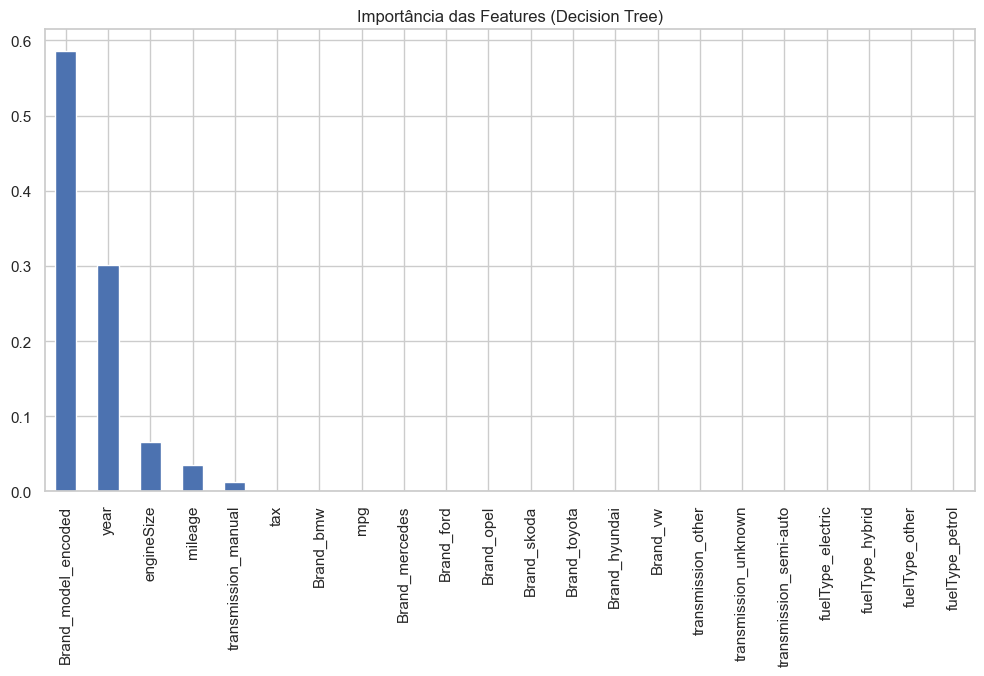

In [11]:
# Comparar Baseline vs Tuned Model usando a função do professor
df_compare = pd.DataFrame(columns=['Time','Train R2','Test R2'], index=['Baseline', 'Tuned DT'])
show_results(df_compare, dt_default, best_dt_model)

# Apresentar a tabela
display(df_compare)

# --- Avaliação Final no conjunto de Validação (X_val_num) ---
print("\n--- Avaliação no Conjunto de Validação ---")
# Previsões
preds_val = best_dt_model.predict(X_val_scaled)

# Métricas
print(f"R2 Score: {r2_score(y_val, preds_val):.4f}")
print(f"MAE: {mean_absolute_error(y_val, preds_val):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, preds_val)):.2f}")

# --- Visualização da Árvore (Opcional, se a profundidade permitir) ---
# Se a árvore for muito profunda, o gráfico fica ilegível, por isso limitamos a visualização
if best_dt_model.get_depth() < 5:
    plt.figure(figsize=(20,10))
    from sklearn import tree
    tree.plot_tree(best_dt_model, 
                   feature_names=X_train_scaled.columns,
                   filled=True, 
                   rounded=True, 
                   fontsize=10)
    plt.show()
else:
    print(f"\nA árvore é muito profunda para visualizar completamente (Profundidade: {best_dt_model.get_depth()}).")
    print("Podes visualizar a importância das features:")
    
    # Visualizar Importância das Features
    importances = pd.Series(best_dt_model.feature_importances_, index=X_train_scaled.columns)
    importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
    plt.title("Importância das Features (Decision Tree)")
    plt.show()

In [12]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_dt_model.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_dt_camp.csv", index=False)
print("Sucesso! Ficheiro 'submission_dt_camp.csv' criado.")

A fazer previsões finais...
Sucesso! Ficheiro 'submission_dt_camp.csv' criado.


modelo é pior a prever carros mais baratos 


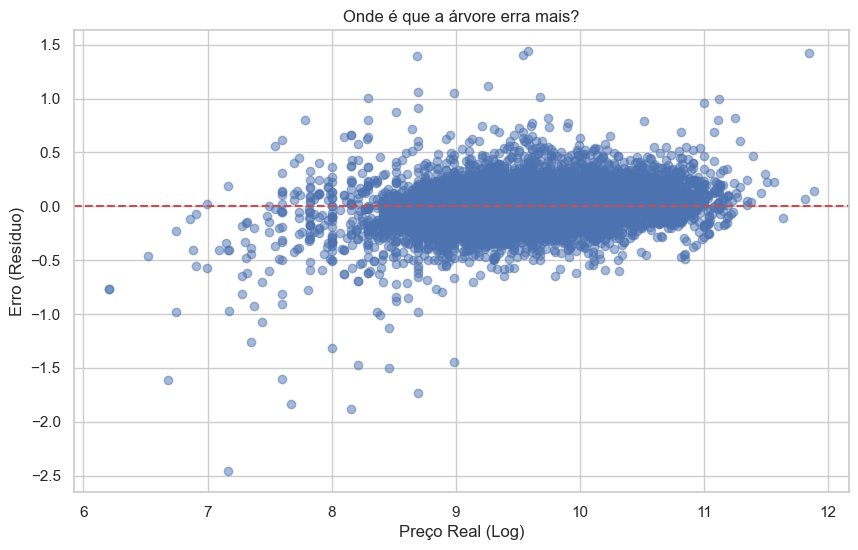

In [18]:
# Calcular resíduos (Erro real vs Previsto)
residuals = y_val - preds_val

plt.figure(figsize=(10,6))
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Preço Real (Log)")
plt.ylabel("Erro (Resíduo)")
plt.title("Onde é que a árvore erra mais?")
plt.show()

antigo bom 

In [ ]:
import pandas as pd  # SE QUISER MELHORAR MESMO O MODELO RETIRO UM BOCADO DOS OUTLIERS PORQUE GB NAO FUNCIONA BEM COM RUIDO
import numpy as np
import functionsML as f
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Função de Limpeza Básica (Sem Leakage)
def clean_data(df):
    df = df.copy()
    
    # Drop irrelevant
    df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
    for col in df.select_dtypes(include="object").columns:
        df = f.fix_typos(col, df)

    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan # Opcional conforme o teu código

    
  #secalhar tenho que fazer diferente esta funcao com logs para rede neuronal , knn etc porque nao estou a usar logs e para esses modelos secalhar é preciso, por isso é quando faço a juncao desses modelos fica pior 
    
    #SUPOSTAMENTE DA MELHOR TIRAR 
   # Numeric Transformations
    df['mileage'] = np.log1p(df['mileage'])
    df['mpg'] = np.log1p(df['mpg'])
    df['tax'] = np.log1p(df['tax'])
    
    # Types and Rounding
    df["year"] = df["year"].round()
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")

    df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")
    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df

novo ricardo

In [ ]:
# import pandas as pd
# import numpy as np
# import functionsML as f
# from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestRegressor
# from scipy.stats import randint

# # Função de Limpeza Básica (Sem Leakage)
# def clean_data(df):
#     df = df.copy()
    
#     # Drop irrelevant
#     df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
#     # Text handling
#     text_cols = df.select_dtypes(include=["object"]).columns
#     df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
#     for col in df.select_dtypes(include="object").columns:
#         df = f.fix_typos(col, df)

#     # Filtering / Cleaning Rules
#     df.loc[df["mileage"] < 0, "mileage"] = np.nan
#     df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
#     df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
#     df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
#     df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
#     df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan # Opcional conforme o teu código

#     # Numeric Transformations
#     df['mileage'] = np.log1p(df['mileage'])
#     df['mpg'] = np.log1p(df['mpg'])
#     df['tax'] = np.log1p(df['tax'])
    
#     # Types and Rounding
#     df["year"] = df["year"].round()
#     df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
#     df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
#  # Imputation
#     df = f.fill_NaN_with_mixed(df, "Brand", cat_cols=["model"], num_cols=["year", "engineSize"])
#     df = f.fill_NaN_with_mixed(df, "model", cat_cols=["Brand"], num_cols=["mpg", "engineSize"])
#     df = f.fill_NaN_with_mixed(df, "transmission", cat_cols=["model"], num_cols=["mpg", "mileage"])
#     df = f.fill_NaN_with_mixed(df, "fuelType", cat_cols=["model"], num_cols=["mpg", "engineSize"])

#     df = f.fill_NaN_with_mixed(df, "year", cat_cols=["model"], num_cols=["mileage", "tax"])
#     df = f.fill_NaN_with_mixed(df, "mileage", cat_cols=["model"], num_cols=["year", "mpg"])
#     df = f.fill_NaN_with_mixed(df, "tax", cat_cols=["model"], num_cols=["year", "mpg"])
#     df = f.fill_NaN_with_mixed(df, "mpg", cat_cols=["model","fuelType"], num_cols=["tax"])
#     df = f.fill_NaN_with_mixed(df, "engineSize", cat_cols=["model"], num_cols=["year", "mpg"])

#     # Fill numeric columns with median
#     df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")

#     # Fills any leftover missing values on numeric columns 
#     numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
#     for col in numeric_cols:
#         df[col] = df[col].astype(float)
#         global_mean = df[col].median()
#         df[col] = df[col].fillna(global_mean)
#         if "Int64" in str(df[col].dtype):
#             df[col] = df[col].round().astype("Int64")

#     # Fill categorical columns with mode
#     cat_cols = df.select_dtypes(include=["object", "category"]).columns
#     for col in cat_cols:
#         global_mode = df[col].mode()
#         if not global_mode.empty:
#             df[col] = df[col].fillna(global_mode[0])

            
#     return df

In [ ]:
# 1. Carregar Dados
train_db = pd.read_csv("./train.csv")
# Importante: Aplicar log no target logo no início se for essa a estratégia
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Separação Inicial)
# Aqui garantimos que a validação nunca vê o treino
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Limpeza Independente (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Onde ocorre o Data Leakage se não tiver cuidado)

# A. One-Hot Encoding
# Temos de garantir colunas iguais. Concatenamos só para gerar as dummies e separamos de novo.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Separar de volta
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT no Treino, TRANSFORM no Treino e Validação)
# Calcular médias no Treino
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Aplicar ao Treino
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Aplicar à Validação (usando o mapping do treino!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. PREPARAÇÃO FINAL (X e y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Colunas a remover

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT no Treino, TRANSFORM em ambos)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

ENSEMBLE 

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (PredefinedSplit)
# -1 = Treino, 0 = Validação
split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 3. Definição do Modelo com OOB Score (Step 12/26 da aula)
# Ativamos o oob_score=True para ter uma métrica extra de validação interna
rf_base = RandomForestRegressor(
    random_state=42, 
    n_jobs=-1,
    bootstrap=True,  # Step 10/22: Amostragem com reposição (Bagging clássico)
    oob_score=True   # Step 8/19: Usar dados não vistos para validação interna
)

# 4. Grelha de Hiperparâmetros baseada na Aula
# Aqui aplicamos os conceitos de Bagging e Random Subspaces
param_dist = {
    # Step 7 e 20: Número de estimadores. 
    # A aula mostrou que aumentar estabiliza o erro, mas tem retornos decrescentes.
    'n_estimators': [100, 200, 300, 400, 500],
    
    # Step 9 e 26: Random Forest / Random Subspaces
    # Quantas features cada árvore vê? 'sqrt' é o padrão de RF, mas testamos outros.
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5], 
    
    # Step 8 e 23: Amostragem (Bagging)
    # Quanto do dataset cada árvore vê?
    # A aula mostrou que usar menos de 100% (ex: 0.5 a 0.9) pode reduzir o overfitting (variância).
    'max_samples': [0.5, 0.7, 0.9, None], 
    
    # Step 24: Profundidade da árvore
    # Controla o overfitting individual de cada "juiz".
    'max_depth': [None, 10, 20, 30, 40],
    
    # Parâmetros extras para garantir robustez nas folhas
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

# 5. Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,    # Testar 50 combinações (pode aumentar se tiver tempo)
    cv=ps,        # Usar a tua divisão treino/validação fixa
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("A iniciar Ensemble Learning (Random Forest Otimizada)...")
random_search.fit(X_combined, y_combined)

# 6. Resultados e OOB Score
best_ensemble = random_search.best_estimator_

print(f"\nMelhores Parâmetros: {random_search.best_params_}")
print(f"Melhor RMSE na Validação (log): {-random_search.best_score_:.4f}")

# Verificar o OOB Score (Step 29 da aula)
# O OOB score no sklearn é R2 por padrão.
print(f"OOB Score (R2 estimado nos dados de treino): {best_ensemble.oob_score_:.4f}")

# --- PREVISÃO FINAL ---
# 7. Preparar dados de teste (Garante que X_test_scaled está definido como no teu código anterior)
# (Assumindo que X_test_scaled já foi criado com o alinhamento de colunas correto)

if 'X_test_scaled' in locals():
    print("A fazer previsões finais...")
    y_test_pred_log = best_ensemble.predict(X_test_scaled)
    y_test_pred_real = np.expm1(y_test_pred_log) # Inverter Log

    # Guardar
    submission = pd.DataFrame({
        "carID": test_db["carID"],
        "price": y_test_pred_real
    })
    submission.to_csv("submission_ensemble_rf.csv", index=False)
    print("Sucesso! 'submission_ensemble_rf.csv' criado.")
else:
    print("AVISO: X_test_scaled não encontrado. Corre o bloco de preparação do teste primeiro.")

A iniciar Ensemble Learning (Random Forest Otimizada)...
Fitting 1 folds for each of 50 candidates, totalling 50 fits

Melhores Parâmetros: {'max_depth': None, 'max_features': 0.5, 'max_samples': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300}
Melhor RMSE na Validação (log): 0.1145
OOB Score (R2 estimado nos dados de treino): 0.9569
A fazer previsões finais...
Sucesso! 'submission_ensemble_rf.csv' criado.


In [7]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)



preds_val = best_ensemble.predict(X_val_scaled)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_ensemble.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_aula.csv", index=False)
print("Sucesso! Ficheiro 'submission_final_campeao.csv' criado.")

A fazer previsões finais...
Sucesso! Ficheiro 'submission_final_campeao.csv' criado.


extra tree, Melhores Parâmetros ET: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30}
1250 etal

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
import pandas as pd
import numpy as np

# 1. Juntar os dados (Se ainda não estiverem juntos)
# Nota: ExtraTrees não precisa de dados "Scaled", mas se passar Scaled não faz mal.
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Split Fixo (Treino vs Validação)
split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 3. Definir o Modelo Base
# n_jobs=-1 usa todos os processadores (O ExtraTrees voa com isto!)
et_base = ExtraTreesRegressor(
    random_state=42, 
    n_jobs=-1,
    bootstrap=False # ExtraTrees geralmente usa o dataset todo, não faz amostragem (bootstrap)
)

# 4. A Grelha de "Força Bruta"
param_dist_et = {
    # # n_estimators: No ExtraTrees, MAIS é sempre MELHOR (só fica mais lento).
    # # Diferente do Boosting, aqui não causa overfitting se aumentar muito.
    # 'n_estimators': [500, 1000, 2000],
    
    # # max_features: O parâmetro MAIS IMPORTANTE do ExtraTrees.
    # # 1.0 = Olha para todas as colunas (bom para dados limpos)
    # # 0.7 = Olha para 70% das colunas (bom para evitar overfitting)
    # # 'sqrt' = Raiz quadrada do nº colunas (clássico para muita variância)
    # 'max_features': [0.7, 0.8, 0.9, 1.0],
    
    # # Profundidade: Deixe o modelo ir fundo, mas controle nas folhas
    # 'max_depth': [None, 20, 30, 40],
    
    # # min_samples_leaf: O travão.
    # # 1 = Muito detalhe (pode decorar)
    # # 5 a 10 = Mais generalista (bom para o seu caso de 75k linhas)
    # 'min_samples_leaf': [1, 2, 4, 8],
    
    # # min_samples_split: Quantos carros são precisos para tentar dividir de novo
    # 'min_samples_split': [2, 5, 10]
    'n_estimators': [500],
    'max_features': [1.0],
    'max_depth': [30],
    'min_samples_leaf': [1],
    'min_samples_split': [10]
}

# 5. Randomized Search
random_search_et = RandomizedSearchCV(
    estimator=et_base,
    param_distributions=param_dist_et,
    n_iter=50,    # Como é rápido, pode testar 50 combinações à vontade
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("A treinar ExtraTreesRegressor (O Caótico Organizado)...")
random_search_et.fit(X_combined, y_combined)

# 6. Resultados
best_et = random_search_et.best_estimator_

print(f"\nMelhores Parâmetros ET: {random_search_et.best_params_}")
print(f"Melhor RMSE (log): {-random_search_et.best_score_:.4f}")

A treinar ExtraTreesRegressor (O Caótico Organizado)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

Melhores Parâmetros ET: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30}
Melhor RMSE (log): 0.1119


In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Recuperar o melhor modelo treinado
best_et = random_search_et.best_estimator_

# 2. Fazer previsões
y_train_pred = best_et.predict(X_train_scaled)
y_val_pred = best_et.predict(X_val_scaled)

# 3. Função auxiliar para calcular métricas
def get_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        "Dataset": dataset_name,
        "R2": r2,
        "MAE": mae,  # Já incluído aqui
        "RMSE": rmse
    }

# 4. Calcular métricas na escala LOG
metrics_train = get_metrics(y_train, y_train_pred, "Treino (Log)")
metrics_val = get_metrics(y_val, y_val_pred, "Validação (Log)")

# 5. Apresentar Tabela Comparativa
df_metrics = pd.DataFrame([metrics_train, metrics_val])
df_metrics.set_index("Dataset", inplace=True)

print("=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===")
print(df_metrics)

# 6. Diagnóstico do Gap (Diferença)
gap_rmse = metrics_val["RMSE"] - metrics_train["RMSE"]
gap_mae = metrics_val["MAE"] - metrics_train["MAE"]  # <--- GAP MAE ADICIONADO
gap_r2 = metrics_train["R2"] - metrics_val["R2"]

print("\n=== DIAGNÓSTICO DE OVERFITTING ===")
print(f"Diferença RMSE (Val - Treino): {gap_rmse:.4f}")
print(f"Diferença MAE  (Val - Treino): {gap_mae:.4f}")
print(f"Queda no R2    (Treino - Val): {gap_r2:.4f}")

if gap_r2 > 0.10 or gap_rmse > 0.05:
    print("⚠️  ALERTA: Há sinais de Overfitting considerável.")
else:
    print("✅  O modelo parece bem ajustado (Generalização sólida).")

# ---------------------------------------------------------
# 7. MÉTRICAS REAIS (EM EUROS)
# ---------------------------------------------------------
print("\n=== MÉTRICAS REAIS (Euros - Aproximado) ===")

# Reverter o Log para valores reais
y_train_real = np.expm1(y_train)
y_val_real = np.expm1(y_val)
y_train_pred_real = np.expm1(y_train_pred)
y_val_pred_real = np.expm1(y_val_pred)

# Cálculo do MAE e RMSE em Euros
mae_real_train = mean_absolute_error(y_train_real, y_train_pred_real)
mae_real_val = mean_absolute_error(y_val_real, y_val_pred_real)

rmse_real_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred_real))
rmse_real_val = np.sqrt(mean_squared_error(y_val_real, y_val_pred_real))

print(f"Treino    -> MAE: € {mae_real_train:.2f}  | RMSE: € {rmse_real_train:.2f}")
print(f"Validação -> MAE: € {mae_real_val:.2f}  | RMSE: € {rmse_real_val:.2f}")

print("-" * 30)
print(f"O teu modelo erra, em média, € {mae_real_val:.2f} no conjunto de validação.")

=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===
                       R2       MAE      RMSE
Dataset                                      
Treino (Log)     0.984042  0.048409  0.067358
Validação (Log)  0.983874  0.049112  0.067351

=== DIAGNÓSTICO DE OVERFITTING ===
Diferença RMSE (Val - Treino): -0.0000
Diferença MAE  (Val - Treino): 0.0007
Queda no R2    (Treino - Val): 0.0002
✅  O modelo parece bem ajustado (Generalização sólida).

=== MÉTRICAS REAIS (Euros - Aproximado) ===
Treino    -> MAE: € 799.29  | RMSE: € 1427.37
Validação -> MAE: € 797.86  | RMSE: € 1296.18
------------------------------
O teu modelo erra, em média, € 797.86 no conjunto de validação.


In [7]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_et.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_EXTRATREE.csv", index=False)
print("Submissão EXTRATREE criada!")

Submissão EXTRATREE criada!


dt bagging que tenho correr


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np

# 1. Configuração dos Dados (Boilerplate padrão)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 2. Definir a Árvore Base (Sem restrições iniciais, a grelha vai tratar disso)
tree_base = DecisionTreeRegressor(random_state=42) 

# 3. Definir o Bagging
bagging_dt = BaggingRegressor(
    estimator=tree_base,
    random_state=42,
    n_jobs=-1
)

# 4. Grelha de Hiperparâmetros (O Segredo)
param_dist_dt = {
    # --- Parâmetros do BAGGING ---
    # n_estimators: Quantas árvores vamos criar?
    'n_estimators': [50, 100, 200], 
    
    # max_samples: Quantas linhas cada árvore vê? (0.7 = 70%)
    # Reduzir isto cria árvores mais diferentes entre si (bom para reduzir variância)
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    
    # max_features: Quantas colunas cada árvore vê?
    # Se for < 1.0, obriga as árvores a aprender caminhos diferentes.
    'max_features': [0.5, 0.7, 0.9, 1.0],
    
    # --- Parâmetros da ÁRVORE (estimator__) ---
    # max_depth: Profundidade da árvore. 
    # Árvores sozinhas fazem overfitting fácil, mas com Bagging podemos deixá-las crescer mais.
    'estimator__max_depth': [None, 10, 20, 40],
    
    # min_samples_split: Mínimo para dividir um nó
    'estimator__min_samples_split': randint(2, 20),
    
    # min_samples_leaf: Mínimo para ser uma folha
    # Valores baixos (1-5) capturam detalhes, valores altos (10+) generalizam.
    'estimator__min_samples_leaf': randint(1, 10)
}

# 5. Randomized Search
random_search_dt = RandomizedSearchCV(
    estimator=bagging_dt,
    param_distributions=param_dist_dt,
    n_iter=50,      # Decision Trees são rápidas, 50 iterações é tranquilo
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("A treinar Bagging com Decision Trees...")
random_search_dt.fit(X_combined, y_combined)

# 6. Resultados
best_bagging_dt = random_search_dt.best_estimator_

print(f"\nMelhores Parâmetros: {random_search_dt.best_params_}")
print(f"Melhor RMSE DT-Bagging (log): {-random_search_dt.best_score_:.4f}")

A treinar Bagging com Decision Trees...
Fitting 1 folds for each of 50 candidates, totalling 50 fits

Melhores Parâmetros: {'estimator__max_depth': 40, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 5, 'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 200}
Melhor RMSE DT-Bagging (log): 0.1142


In [ ]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Pipeline de Limpeza (Certifique-se que clean_data, mapping, etc. estão na memória)
test_db = clean_data(test_db) 
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# Alinhamento
cols_treino = X_combined.columns 
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# Scaling
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 3. PREVISÃO
print("A fazer previsões finais com Decision Tree Bagging...")
y_test_pred_log = best_bagging_dt.predict(X_test_scaled)

# 4. INVERTER O LOG
y_test_pred_real = np.expm1(y_test_pred_log)

# 5. GUARDAR
submission = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_test_pred_real
})

filename = "submission_decision_tree_bagging.csv"
submission.to_csv(filename, index=False)
print(f"Sucesso! Ficheiro '{filename}' criado.")

KNN, sem bagging era 0.1316, com bagging 

In [6]:
from sklearn.neighbors import KNeighborsRegressor

# --- CONFIGURAÇÃO PARA KNN ---
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)

# 1. Definir o Modelo Base
knn_model = KNeighborsRegressor(n_jobs=-1)

# 2. Definir a Grelha de Hiperparâmetros
param_dist_knn = {
    # n_neighbors: 'K'. Valores baixos (3) ajustam muito, altos (50) generalizam.
    'n_neighbors': randint(3, 50),
    
    # weights: 
    # 'uniform' = todos os vizinhos valem o mesmo.
    # 'distance' = vizinhos mais próximos têm mais peso (geralmente melhor para preços)
    'weights': ['uniform', 'distance'],
    
    # metric: Como medir a distância entre os carros
    # 'manhattan' (L1) costuma funcionar bem com muitas colunas (high-dim)
    # 'euclidean' (L2) é o padrão geométrico
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    
    # p: Só é usado se metric='minkowski' (1=Manhattan, 2=Euclidean)
    'p': [1, 2]
}

# 3. Configurar RandomizedSearchCV (Usando o MESMO 'ps' e 'X_combined')
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=50,     # KNN é muito rápido, podemos testar 30 combinações
    cv=ps,         # Reutilizamos o PredefinedSplit criado no passo anterior
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para KNN com Predefined Split...")
# IMPORTANTE: X_combined já está escalado (MinMaxScaler), o que é obrigatório para KNN!
random_search_knn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros KNN: {random_search_knn.best_params_}")
print(f"Melhor RMSE KNN (log): {-random_search_knn.best_score_:.4f}")

# O melhor modelo KNN já fica treinado com TUDO
best_knn = random_search_knn.best_estimator_



A iniciar Random Search para KNN com Predefined Split...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Melhores Parâmetros KNN: {'metric': 'manhattan', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Melhor RMSE KNN (log): 0.1316


In [30]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_knn.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn.csv", index=False)
print("Submissão KNN criada!")

Submissão KNN criada!


bagging knn, que tenho correr 

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint, uniform
import pandas as pd

# 1. Configuração dos Dados (Igual ao que já tinha)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 2. Definir o KNN Base
# Nota: Não definimos n_jobs=-1 aqui para não entrar em conflito com o n_jobs do Bagging
knn_base = KNeighborsRegressor() 

# 3. Definir o Bagging com KNN
# O Bagging vai criar várias cópias deste knn_base
bagging_knn = BaggingRegressor(
    estimator=knn_base,
    random_state=42,
    n_jobs=-1  # Usa todos os processadores para treinar os modelos em paralelo
)

# 4. Grelha de Hiperparâmetros (Híbrida)
# Aqui ajustamos o Bagging E o KNN ao mesmo tempo
param_dist_bagging = {
    # --- Parâmetros do BAGGING (O "Chefe") ---
    # Quantos modelos KNN vamos criar? (10 a 100)
    'n_estimators': [10, 30, 50, 100], 
    
    # Quantas linhas (amostras) cada KNN vê? (0.5 = 50% dos dados, 1.0 = tudo)
    # Reduzir isto aumenta a diversidade e reduz overfitting
    'max_samples': [0.5, 0.7, 0.8, 1.0],
    
    # Quantas colunas (features) cada KNN vê? 
    # Ótimo para garantir que eles não olham todos para as mesmas coisas
    'max_features': [0.7, 0.8, 0.9, 1.0],
    
    # --- Parâmetros do KNN Interno (O "Trabalhador") ---
    # Atenção à sintaxe: "estimator__nome_do_parametro"
    'estimator__n_neighbors': randint(3, 40),
    'estimator__weights': ['distance', 'uniform'],
    'estimator__metric': ['manhattan', 'euclidean'],
    'estimator__p': [1, 2]
}

# 5. Randomized Search
random_search_bagging = RandomizedSearchCV(
    estimator=bagging_knn,
    param_distributions=param_dist_bagging,
    n_iter=30,      # CUIDADO: Bagging de KNN é pesado. 30 iterações podem demorar um pouco.
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,      # Processamento paralelo máximo
    random_state=42
)

# 6. Executar
print("A treinar Bagging com KNN... (Isto pode demorar uns minutos)")
random_search_bagging.fit(X_combined, y_combined)

# 7. Resultados
best_bagging_knn = random_search_bagging.best_estimator_

print(f"\nMelhores Parâmetros: {random_search_bagging.best_params_}")
print(f"Melhor RMSE Bagging-KNN (log): {-random_search_bagging.best_score_:.4f}")

# ----------------------------------------------------
# SEÇÃO PARA GUARDAR / PREVER (Opcional, se quiser testar já)
# ----------------------------------------------------
# y_pred_log = best_bagging_knn.predict(X_test_scaled)
# y_pred_real = np.expm1(y_pred_log)

A treinar Bagging com KNN... (Isto pode demorar uns minutos)
Fitting 1 folds for each of 30 candidates, totalling 30 fits

Melhores Parâmetros: {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 11, 'estimator__p': 2, 'estimator__weights': 'distance', 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}
Melhor RMSE Bagging-KNN (log): 0.1263


In [ ]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_bagging_knn.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn.csv", index=False)
print("Submissão KNN criada!")

REDE NEURONAL

In [31]:
from sklearn.neural_network import MLPRegressor

# --- CONFIGURAÇÃO PARA REDE NEURAL (MLP) ---
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)



# 1. Definir o Modelo Base
# max_iter=1000 dá tempo à rede para aprender sem parar cedo demais
# early_stopping=True ajuda a parar se não estiver a aprender (poupa tempo)
nn_model = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)

# 2. Definir a Grelha de Hiperparâmetros
param_dist = {
    # Arquitetura: Testamos desde redes simples até muito profundas/largas
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)  ###incluir sempre os defaults
    ],
    
    # Ativação: A Tanh por vezes lida melhor com regressão do que a ReLU
    'activation': ['relu', 'tanh', 'logistic'],
    
    # Solver: O SGD é clássico, Adam é moderno, LBFGS é bom para dados pequenos
    'solver': ['adam', 'sgd', 'lbfgs'],
    
    # alpha: Regularização L2 (para evitar overfitting)
    # Valores pequenos (0.0001) a moderados (0.05)
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    
    'batch_size': [32, 64, 'auto'],
    # Learning Rate: Importante para o SGD
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    
    
    # Early Stopping: Ativar para evitar overfitting
    'early_stopping': [True],
    #como tenho early stopping 
    # Validation Fraction: Quanto dos dados de treino usar para parar cedo (se early_stopping=True)
    'validation_fraction': [0.1, 0.2]
}

param_dist_nn = {
    # hidden_layer_sizes: Define a "arquitetura" da rede (neurónios por camada)
    # (50,) -> 1 camada com 50 neurónios
    # (100, 50) -> 2 camadas (100 na primeira, 50 na segunda)
    # (100, 50, 25) -> 3 camadas (Rede profunda)
    'hidden_layer_sizes': [
        (50,), (100,), 
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25)
    ],
    
    # activation: A "fórmula" que cada neurónio usa
    # 'relu' é o padrão moderno, 'tanh' às vezes funciona bem para regressão
    'activation': ['relu', 'tanh'],
    
    # solver: O algoritmo que ajusta os pesos
    # 'adam' funciona bem quase sempre, 'sgd' pode ser melhor mas requer ajuste fino
    'solver': ['adam'],
    
    # alpha: Regularização L2 (para evitar overfitting)
    # Valores pequenos (0.0001) a moderados (0.05)
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    
    # learning_rate_init: A velocidade de aprendizagem inicial
    'learning_rate_init': [0.001, 0.01]
}

# 3. Randomized Search
random_search_nn = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=param_dist,
    n_iter=50,     # Testar 50 arquiteturas diferentes
    cv=ps,         # O TEU SPLIT PERSONALIZADO
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para Rede Neural...")
# IMPORTANTE: X_combined tem de estar ESCALADO!
random_search_nn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros NN: {random_search_nn.best_params_}")
print(f"Melhor RMSE NN (log): {-random_search_nn.best_score_:.4f}")

# Guardar o campeão
best_nn = random_search_nn.best_estimator_

A iniciar Random Search para Rede Neural...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Melhores Parâmetros NN: {'validation_fraction': 0.2, 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (200, 100), 'early_stopping': True, 'batch_size': 64, 'alpha': 0.0001, 'activation': 'relu'}
Melhor RMSE NN (log): 0.1388


In [32]:
# --- GERAR SUBMISSÃO PARA A REDE NEURAL ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 3. Encoding
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Target Encode
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. Alinhamento de Colunas (Obrigatório)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_nn = test_encoded.drop(columns=drop_cols, errors='ignore')

# Garante que o teste tem as mesmas colunas que o treino
cols_treino = X_combined.columns 
X_test_nn = X_test_nn.reindex(columns=cols_treino, fill_value=0)

# 5. SCALING (Obrigatório: Usar o scaler do treino)
X_test_nn_scaled = pd.DataFrame(scaler.transform(X_test_nn), columns=X_test_nn.columns, index=X_test_nn.index)

# 6. Previsão
print("A prever com a Rede Neural...")
y_pred_nn_log = best_nn.predict(X_test_nn_scaled)

# Inverter Log
y_pred_nn_real = np.expm1(y_pred_nn_log)

# 7. Guardar
submission_nn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_nn_real
})
submission_nn.to_csv("submission_nn.csv", index=False)
print("Submissão Neural Network criada!")

A prever com a Rede Neural...
Submissão Neural Network criada!


RANDOM FOREST RODRIGO 

In [ ]:
# 1. Juntar os dados processados (Reset index para garantir alinhamento)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (test_fold)
# -1 indica: "Este dado é de treino, usa para aprender"
#  0 indica: "Este dado é de validação, usa para testar" (0 é o índice do fold de validação)

# Array com -1 para o tamanho do treino
split_index_train = [-1] * len(X_train_scaled)
# Array com 0 para o tamanho da validação
split_index_val = [0] * len(X_val_scaled)

# Juntar os dois
test_fold = split_index_train + split_index_val

# 3. Criar o Objeto PredefinedSplit
ps = PredefinedSplit(test_fold)

# 4. Configurar o RandomizedSearchCV com cv=ps
# Exemplo com Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,    # Número de tentativas
    cv=ps,        # <--- AQUI ESTÁ O TRUQUE: Usamos o nosso split personalizado
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Executar a Busca
print("A iniciar Random Search com Predefined Split...")
# Passamos o X_combined e y_combined. Ele vai saber separar internamente graças ao 'ps'.
random_search.fit(X_combined, y_combined)

# 6. Resultados
print(f"Melhores Parâmetros: {random_search.best_params_}")
print(f"Melhor RMSE (log): {-random_search.best_score_:.4f}")

# O melhor modelo já fica treinado com TUDO (Treino + Validação) se refit=True (default)
best_model = random_search.best_estimator_

A iniciar Random Search com Predefined Split...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Melhores Parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 267}
Melhor RMSE (log): 0.1161


In [13]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)



preds_val = best_model.predict(X_val_scaled)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_model.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_final_campeao.csv", index=False)
print("Sucesso! Ficheiro 'submission_final_campeao.csv' criado.")

A fazer previsões finais...
Sucesso! Ficheiro 'submission_final_campeao.csv' criado.


grading boost , O LEAF E O SPLIT NAO VAO CAUSAR OVERFIT PORQUE ESTAO IGUAL OU ACIMA DE 10 ( FOI O QUE O MODELO ESCOLHEU ) , SE EU QUISER MAIS PONTOS É SO AUMENTAR O ESTIMATORS DE 500 EM 500

Melhores Parâmetros GB: {'learning_rate': 0.01, 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 2500, 'subsample': 0.7}
1188, nao me lembro quais foram os parametro que deu 1179

In [4]:
from sklearn.ensemble import GradientBoostingRegressor # <--- A versão permitida!
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np

# 1. Juntar os dados (Igual aos passos anteriores)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split
split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 3. Definir o Modelo Gradient Boosting do Sklearn
# loss='squared_error' é o equivalente a minimizar o erro quadrático
gb_base = GradientBoostingRegressor(
    loss='squared_error',
    random_state=42
)

# 4. Grelha de Hiperparâmetros (Adaptada para Sklearn)
param_dist = {
    # # n_estimators: Número de árvores sequenciais
    # 'n_estimators': [2500, 3000],  # estava 1500, 2000//(2500) DEU MELHOR foi quando fiz 2000 , 2500
    
    # # learning_rate: A velocidade de correção. 
    # # Menor (0.01) exige mais árvores, mas geralmente dá melhor resultado.
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
   
    
    # # max_depth: Profundidade máxima de cada árvore (Boosting prefere árvores pequenas, 3-5)
    # 'max_depth': randint(3, 40),
    
    # # min_samples_split: Mínimo de amostras para dividir um nó (evita overfitting)
    # 'min_samples_split': randint(2, 30),
    
    # # min_samples_leaf: Mínimo de amostras numa folha
    # 'min_samples_leaf': randint(1, 20),
    
    # # subsample: Fração de amostras usadas para treinar cada árvore.
    # # < 1.0 chama-se "Stochastic Gradient Boosting" e reduz a variância.
    # 'subsample': [0.7, 0.8, 0.9, 1.0],
    
    # # max_features: Quantas colunas olhar em cada divisão
    # 'max_features': ['sqrt', 'log2', None]
    
    'learning_rate': [0.01],
    'max_depth': [14],
    'max_features': ['log2'],
    'min_samples_leaf': [7],
    'min_samples_split': [3],
    'n_estimators': [2500],
    'subsample': [0.7]
}

# 5. Randomized Search
random_search_gb = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=50,    # Testar 50 combinações
    cv=ps,        # O teu split fixo
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,    # Usa todos os cores
    random_state=42
)

print("A treinar Gradient Boosting (Vanilla Sklearn)... 100% Seguro!")
random_search_gb.fit(X_combined, y_combined)

# 6. Resultados
best_gb = random_search_gb.best_estimator_

print(f"\nMelhores Parâmetros GB: {random_search_gb.best_params_}")
print(f"Melhor RMSE (log): {-random_search_gb.best_score_:.4f}")

A treinar Gradient Boosting (Vanilla Sklearn)... 100% Seguro!
Fitting 1 folds for each of 1 candidates, totalling 1 fits

Melhores Parâmetros GB: {'subsample': 0.7, 'n_estimators': 2500, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 14, 'learning_rate': 0.01}
Melhor RMSE (log): 0.1056


In [6]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Recuperar o melhor modelo treinado
best_gb = random_search_gb.best_estimator_

# 2. Fazer previsões
y_train_pred = best_gb.predict(X_train_scaled)
y_val_pred = best_gb.predict(X_val_scaled)

# 3. Função auxiliar para calcular métricas
def get_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        "Dataset": dataset_name,
        "R2": r2,
        "MAE": mae,  # Já incluído aqui
        "RMSE": rmse
    }

# 4. Calcular métricas na escala LOG
metrics_train = get_metrics(y_train, y_train_pred, "Treino (Log)")
metrics_val = get_metrics(y_val, y_val_pred, "Validação (Log)")

# 5. Apresentar Tabela Comparativa
df_metrics = pd.DataFrame([metrics_train, metrics_val])
df_metrics.set_index("Dataset", inplace=True)

print("=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===")
print(df_metrics)

# 6. Diagnóstico do Gap (Diferença)
gap_rmse = metrics_val["RMSE"] - metrics_train["RMSE"]
gap_mae = metrics_val["MAE"] - metrics_train["MAE"]  # <--- GAP MAE ADICIONADO
gap_r2 = metrics_train["R2"] - metrics_val["R2"]

print("\n=== DIAGNÓSTICO DE OVERFITTING ===")
print(f"Diferença RMSE (Val - Treino): {gap_rmse:.4f}")
print(f"Diferença MAE  (Val - Treino): {gap_mae:.4f}")
print(f"Queda no R2    (Treino - Val): {gap_r2:.4f}")

if gap_r2 > 0.10 or gap_rmse > 0.05:
    print("⚠️  ALERTA: Há sinais de Overfitting considerável.")
else:
    print("✅  O modelo parece bem ajustado (Generalização sólida).")

# ---------------------------------------------------------
# 7. MÉTRICAS REAIS (EM EUROS)
# ---------------------------------------------------------
print("\n=== MÉTRICAS REAIS (Euros - Aproximado) ===")

# Reverter o Log para valores reais
y_train_real = np.expm1(y_train)
y_val_real = np.expm1(y_val)
y_train_pred_real = np.expm1(y_train_pred)
y_val_pred_real = np.expm1(y_val_pred)

# Cálculo do MAE e RMSE em Euros
mae_real_train = mean_absolute_error(y_train_real, y_train_pred_real)
mae_real_val = mean_absolute_error(y_val_real, y_val_pred_real)

rmse_real_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred_real))
rmse_real_val = np.sqrt(mean_squared_error(y_val_real, y_val_pred_real))

print(f"Treino    -> MAE: € {mae_real_train:.2f}  | RMSE: € {rmse_real_train:.2f}")
print(f"Validação -> MAE: € {mae_real_val:.2f}  | RMSE: € {rmse_real_val:.2f}")

print("-" * 30)
print(f"O teu modelo erra, em média, € {mae_real_val:.2f} no conjunto de validação.")

=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===
                       R2       MAE      RMSE
Dataset                                      
Treino (Log)     0.981250  0.053764  0.073012
Validação (Log)  0.980951  0.054452  0.073203

=== DIAGNÓSTICO DE OVERFITTING ===
Diferença RMSE (Val - Treino): 0.0002
Diferença MAE  (Val - Treino): 0.0007
Queda no R2    (Treino - Val): 0.0003
✅  O modelo parece bem ajustado (Generalização sólida).

=== MÉTRICAS REAIS (Euros - Aproximado) ===
Treino    -> MAE: € 896.24  | RMSE: € 1489.37
Validação -> MAE: € 902.88  | RMSE: € 1414.65
------------------------------
O teu modelo erra, em média, € 902.88 no conjunto de validação.


In [5]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)



preds_val = best_gb.predict(X_val_scaled)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_gb.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_gTeixeira.csv", index=False)
print("Sucesso! Ficheiro 'submission_gb.csv' criado.") 

A fazer previsões finais...
Sucesso! Ficheiro 'submission_gb.csv' criado.


HIST GRADING BOOST,Melhores Parâmetros HistGB: {'max_leaf_nodes': 80, 'max_iter': 3000, 'max_features': 0.3, 'max_depth': 10, 'learning_rate': 0.05, 'l2_regularization': 0.5}

      resultado   1188

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import randint
import pandas as pd
import numpy as np

# 1. Juntar os dados (X_train_scaled e X_val_scaled devem existir na memória)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split
# -1 = Treino, 0 = Validação
split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# 3. Definir o Modelo HistGradientBoosting
hgb_base = HistGradientBoostingRegressor(
    loss='squared_error',
    random_state=42,
    early_stopping=False # Desligado aqui porque usamos CV fixo
)

# 4. Grelha de Hiperparâmetros
param_dist = {
# 1. Potência
    # 'max_iter': [3000, 5000, 10000], 
    # 'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2], 
    
    # # 2. Estrutura da Árvore
    # 'max_leaf_nodes': randint(20, 128), 
    # 'max_depth': randint(3, 40),
    
    # # 3. Robustez
    # 'min_samples_leaf': randint(10, 100),
    # 'l2_regularization': [0, 0.1, 1.0, 5.0, 10.0],
    
    # # 4. Resolução (Binning)
    # 'max_bins': [63, 127, 255],
    
    # # 5. SUBSTITUIÇÃO: max_features em vez de subsample
    # # Isto define a % de colunas que o modelo olha a cada divisão.
    # # 1.0 = olha para tudo, 0.8 = olha para 80% das features. Ajuda muito no overfitting!
    # 'max_features': [0.8, 0.9, 1.0]
    
#    #O DE BAIXO É O MELHOR 



#     # 1. Forçar Regularização (O segredo para bater o GB)
#     # Nunca permita 0 aqui, para obrigar o modelo a generalizar
#     'l2_regularization': [0.5, 1.0, 5.0, 10.0], 
    
#     # 2. Controlar a Complexidade
#     # 118 folhas é muito. Vamos testar valores mais baixos.
#     'max_leaf_nodes': [31, 50, 80], 
#     'max_depth': [10, 15, 20], # Limitar a profundidade também
    
#     # 3. Features e Learning Rate
#     'learning_rate': [0.01, 0.02, 0.05],
#     'max_iter': [3000, 5000],
    
#     # IMPORTANTE: Tentar simular o 'log2' do GB
#     # Baixar isto obriga cada árvore a ser mais independente
#     'max_features': [0.3, 0.5, 0.7] 

        # 1. Forçar Regularização (O segredo para bater o GB)
    # Nunca permita 0 aqui, para obrigar o modelo a generalizar
    'l2_regularization': [0.5], 
    
    # 2. Controlar a Complexidade
    # 118 folhas é muito. Vamos testar valores mais baixos.
    'max_leaf_nodes': [80], 
    'max_depth': [10], # Limitar a profundidade também
    
    # 3. Features e Learning Rate
    'learning_rate': [0.05],
    'max_iter': [3000],
    
    # IMPORTANTE: Tentar simular o 'log2' do GB
    # Baixar isto obriga cada árvore a ser mais independente
    'max_features': [0.3] 


}



# 5. Randomized Search
random_search_hgb = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=param_dist,
    n_iter=50,    # Testar 50 combinações
    cv=ps,        # O teu split fixo
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,    # Usa todos os cores
    random_state=42
)

print("A treinar HistGradientBoosting (Modo Rápido)...")
random_search_hgb.fit(X_combined, y_combined)

# 6. Resultados e Guardar o Melhor Modelo
best_hgb = random_search_hgb.best_estimator_

print(f"\nMelhores Parâmetros HistGB: {random_search_hgb.best_params_}")
print(f"Melhor RMSE (log): {-random_search_hgb.best_score_:.4f}")

A treinar HistGradientBoosting (Modo Rápido)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

Melhores Parâmetros HistGB: {'max_leaf_nodes': 80, 'max_iter': 3000, 'max_features': 0.3, 'max_depth': 10, 'learning_rate': 0.05, 'l2_regularization': 0.5}
Melhor RMSE (log): 0.1057


In [10]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)



preds_val = best_hgb.predict(X_val_scaled)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_hgb.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_histgradingBoost.csv", index=False)
print("Sucesso! Ficheiro 'submission_final_campeao.csv' criado.") 

A fazer previsões finais...
Sucesso! Ficheiro 'submission_final_campeao.csv' criado.


In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Recuperar o melhor modelo treinado
best_hgb = random_search_gb.best_estimator_

# 2. Fazer previsões
y_train_pred = best_hgb.predict(X_train_scaled)
y_val_pred = best_hgb.predict(X_val_scaled)

# 3. Função auxiliar para calcular métricas
def get_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        "Dataset": dataset_name,
        "R2": r2,
        "MAE": mae,  # Já incluído aqui
        "RMSE": rmse
    }

# 4. Calcular métricas na escala LOG
metrics_train = get_metrics(y_train, y_train_pred, "Treino (Log)")
metrics_val = get_metrics(y_val, y_val_pred, "Validação (Log)")

# 5. Apresentar Tabela Comparativa
df_metrics = pd.DataFrame([metrics_train, metrics_val])
df_metrics.set_index("Dataset", inplace=True)

print("=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===")
print(df_metrics)

# 6. Diagnóstico do Gap (Diferença)
gap_rmse = metrics_val["RMSE"] - metrics_train["RMSE"]
gap_mae = metrics_val["MAE"] - metrics_train["MAE"]  # <--- GAP MAE ADICIONADO
gap_r2 = metrics_train["R2"] - metrics_val["R2"]

print("\n=== DIAGNÓSTICO DE OVERFITTING ===")
print(f"Diferença RMSE (Val - Treino): {gap_rmse:.4f}")
print(f"Diferença MAE  (Val - Treino): {gap_mae:.4f}")
print(f"Queda no R2    (Treino - Val): {gap_r2:.4f}")

if gap_r2 > 0.10 or gap_rmse > 0.05:
    print("⚠️  ALERTA: Há sinais de Overfitting considerável.")
else:
    print("✅  O modelo parece bem ajustado (Generalização sólida).")

# ---------------------------------------------------------
# 7. MÉTRICAS REAIS (EM EUROS)
# ---------------------------------------------------------
print("\n=== MÉTRICAS REAIS (Euros - Aproximado) ===")

# Reverter o Log para valores reais
y_train_real = np.expm1(y_train)
y_val_real = np.expm1(y_val)
y_train_pred_real = np.expm1(y_train_pred)
y_val_pred_real = np.expm1(y_val_pred)

# Cálculo do MAE e RMSE em Euros
mae_real_train = mean_absolute_error(y_train_real, y_train_pred_real)
mae_real_val = mean_absolute_error(y_val_real, y_val_pred_real)

rmse_real_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred_real))
rmse_real_val = np.sqrt(mean_squared_error(y_val_real, y_val_pred_real))

print(f"Treino    -> MAE: € {mae_real_train:.2f}  | RMSE: € {rmse_real_train:.2f}")
print(f"Validação -> MAE: € {mae_real_val:.2f}  | RMSE: € {rmse_real_val:.2f}")

print("-" * 30)
print(f"O teu modelo erra, em média, € {mae_real_val:.2f} no conjunto de validação.")

=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===
                       R2       MAE      RMSE
Dataset                                      
Treino (Log)     0.981250  0.053764  0.073012
Validação (Log)  0.980951  0.054452  0.073203

=== DIAGNÓSTICO DE OVERFITTING ===
Diferença RMSE (Val - Treino): 0.0002
Diferença MAE  (Val - Treino): 0.0007
Queda no R2    (Treino - Val): 0.0003
✅  O modelo parece bem ajustado (Generalização sólida).

=== MÉTRICAS REAIS (Euros - Aproximado) ===
Treino    -> MAE: € 896.24  | RMSE: € 1489.37
Validação -> MAE: € 902.88  | RMSE: € 1414.65
------------------------------
O teu modelo erra, em média, € 902.88 no conjunto de validação.


In [17]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)



preds_val = best_hgb.predict(X_val_scaled)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_hgb.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_histgradingBoost.csv", index=False)
print("Sucesso! Ficheiro 'submission_final_campeao.csv' criado.") 

A fazer previsões finais...
Sucesso! Ficheiro 'submission_final_campeao.csv' criado.


assemble (juncao de modelos), o melhor foi gb com rf em que pus peso 7,1 

In [8]:
from sklearn.ensemble import VotingRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit # FALTA ADICIONAR REDE NEURONAL ETC , E DAR PESO DIFERENTE A CADA MODLEO 

# 1. Juntar os dados processados (Reset index para garantir alinhamento)
# Assumindo que X_train_scaled, X_val_scaled, y_train, y_val já existem em memória
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Criar a "Máscara" de Split (opcional aqui se não usar GridSearch, mas boa prática)
split_index_train = [-1] * len(X_train_scaled)
split_index_val = [0] * len(X_val_scaled)
test_fold = split_index_train + split_index_val
ps = PredefinedSplit(test_fold)

# 3. Recuperar os melhores modelos (Garantir que existem)
estimators_list = []

# Adicionar Gradient Boosting (Se existir)
if 'best_gb' in locals():
    estimators_list.append(('gb', best_gb))
    print("Modelo GB adicionado ao Ensemble.")

# Adicionar Random Forest (Se existir)
if 'best_model' in locals(): # Assumindo que 'best_model' é a RF do passo anterior
    estimators_list.append(('rf', best_model))
    print("Modelo RF adicionado ao Ensemble.")

# # Adicionar Extra Trees (Se existir)
# if 'best_ensemble' in locals():
#     estimators_list.append(('et', best_ensemble))
#     print("Modelo ET adicionado ao Ensemble.")

# # Adicionar Árvore de Decisão (Se existir)
# if 'best_dt_model' in locals():
#     estimators_list.append(('dt', best_dt_model))
#     print("Modelo DT adicionado ao Ensemble.")

# # Adicionar Árvore de Decisão (Se existir)
# if 'best_knn' in locals():
#     estimators_list.append(('knn', best_knn))
#     print("Modelo Knn adicionado ao Ensemble.")

# # Adicionar Árvore de Decisão (Se existir)
# if 'best_nn' in locals():
#     estimators_list.append(('nn', best_nn))
#     print("Modelo NN adicionado ao Ensemble.")




if not estimators_list:
    raise ValueError("ERRO: Nenhum modelo encontrado! Treine os modelos individuais primeiro.")


# 4. Definir e Treinar o Voting Regressor
# Pode adicionar pesos se quiser dar mais força ao GB (ex: weights=[2, 1, 1])
voting_model = VotingRegressor(
    estimators=estimators_list,
    weights=[7, 1],
    n_jobs=-1
)

print(f"\nA treinar o 'Super Modelo' (Voting com {len(estimators_list)} modelos)...")
voting_model.fit(X_combined, y_combined)
print("✅ Super Modelo treinado com sucesso!")

Modelo GB adicionado ao Ensemble.
Modelo RF adicionado ao Ensemble.

A treinar o 'Super Modelo' (Voting com 2 modelos)...
✅ Super Modelo treinado com sucesso!


In [9]:
# --- PREPARAÇÃO E SUBMISSÃO ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usar a mesma função 'clean_data' definida no início do notebook)
test_db = clean_data(test_db) 

# 3. ENCODING

# A. One-Hot Encoding
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' do TREINO
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("ERRO: 'mapping' ou 'global_mean' não encontrados. Corra o treino primeiro.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover colunas irrelevantes
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina")
# Garante que o teste tem as mesmas colunas que o modelo espera (X_combined)
cols_treino = X_combined.columns 
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO COM O SUPER MODELO
print("A fazer previsões com o Voting Regressor...")
y_test_pred_log = voting_model.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

filename = "submission_voting_ensemble.csv"
submission.to_csv(filename, index=False)
print(f"Sucesso! Ficheiro '{filename}' criado.")

A fazer previsões com o Voting Regressor...
Sucesso! Ficheiro 'submission_voting_ensemble.csv' criado.


VONTING REGRESSOR ( OU SEJA A MESMA QUE O ANTERIOR) SÓ QUE ESTE TEM RANDOM SEARCH NOS PESOS 

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
import pandas as pd
import numpy as np
import random

# --- 1. PREPARAR DADOS (TREINO + VALIDAÇÃO) ---
# Juntar os dados já processados para treinar o modelo final com tudo
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Criar a máscara de split para o RandomizedSearch saber o que é treino (-1) e validação (0)
split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# --- 2. RECUPERAR MODELOS (CONSTRUIR A EQUIPA) ---
estimators_list = []

# Adicione todos os modelos que tiver disponíveis na memória
# if 'best_gb' in locals(): 
#     estimators_list.append(('gb', best_gb))
#     print("✅ Gradient Boosting adicionado.")

if 'best_model' in locals(): # Assumindo que best_model é a Random Forest
    estimators_list.append(('rf', best_model))
    print("✅ Random Forest adicionada.")

if 'best_et' in locals(): 
    estimators_list.append(('et', best_et))
    print("✅ Extra Trees adicionada.")
    
if 'best_knn' in locals(): 
    estimators_list.append(('knn', best_knn))
    print("✅ KNN adicionado.")
    
# if 'best_nn' in locals(): 
#     estimators_list.append(('nn', best_nn))
#     print("✅ Rede Neuronal adicionada.")

# if 'best_dt_model' in locals(): 
#     estimators_list.append(('dt', best_dt_model))
#     print("✅ Árvore de Decisão adicionada.")

if 'best_hgb' in locals(): 
    estimators_list.append(('hgb', best_hgb))
    print("✅  Hist Granding Boost adicionado.")


if not estimators_list:
    raise ValueError("ERRO CRÍTICO: Nenhum modelo encontrado! Treine os modelos individuais primeiro.")

n_models = len(estimators_list)
print(f"\nEquipa completa ({n_models} modelos): {[name for name, _ in estimators_list]}")

# --- 3. OTIMIZAR PESOS (RANDOM SEARCH) ---
# Em vez de adivinhar pesos, vamos testar 50 combinações aleatórias
random.seed(42)
weights_combinations = []

for _ in range(50): 
    # Gera uma lista de N pesos aleatórios entre 1 e 5 (ex: [1, 3, 2])
    w = [random.randint(1, 10) for _ in range(n_models)]
    weights_combinations.append(w)

# Adicionar combinações manuais "lógicas" para garantir que são testadas
# (Dá mais peso ao GB se ele estiver na lista, posição 0)
if n_models >= 2:
    manual_weight = [1] * n_models
    manual_weight[0] = 3 # Tenta dar peso triplo ao primeiro modelo (GB)
    weights_combinations.append(manual_weight)

# Configurar a grelha de pesquisa
param_grid = {
    'weights': weights_combinations
}

# Criar o VotingRegressor base
voting_base = VotingRegressor(estimators=estimators_list, n_jobs=-1)

# Configurar a busca
random_search_weights = RandomizedSearchCV(
    estimator=voting_base,
    param_distributions=param_grid,
    n_iter=50, # Testa 50 combinações
    cv=ps,     # Usa o teu split de validação fixo
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(f"\nA otimizar os pesos do Super Modelo (testando {len(weights_combinations)} combinações)...")
random_search_weights.fit(X_combined, y_combined)

# --- 4. RESULTADO FINAL ---
# O best_ensemble já é o modelo treinado com os melhores pesos encontrados
best_ensemble = random_search_weights.best_estimator_

print(f"\n🏆 MELHOR COMBINAÇÃO DE PESOS: {random_search_weights.best_params_['weights']}")
print(f"📉 Melhor RMSE do Ensemble (log): {-random_search_weights.best_score_:.4f}")
print("O Super Modelo 'best_ensemble' está pronto a usar!")

✅ Extra Trees adicionada.
✅  Hist Granding Boost adicionado.

Equipa completa (2 modelos): ['et', 'hgb']

A otimizar os pesos do Super Modelo (testando 51 combinações)...
Fitting 1 folds for each of 50 candidates, totalling 50 fits

🏆 MELHOR COMBINAÇÃO DE PESOS: [2, 6]
📉 Melhor RMSE do Ensemble (log): 0.1050
O Super Modelo 'best_ensemble' está pronto a usar!


In [10]:
# --- PREPARAÇÃO E SUBMISSÃO ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usar a mesma função 'clean_data' definida no início do notebook)
test_db = clean_data(test_db) 

# 3. ENCODING

# A. One-Hot Encoding
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' do TREINO
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("ERRO: 'mapping' ou 'global_mean' não encontrados. Corra o treino primeiro.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover colunas irrelevantes
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina")
# Garante que o teste tem as mesmas colunas que o modelo espera (X_combined)
# (Assumindo que X_combined foi criado na Célula 1)
cols_treino = X_combined.columns 
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado no início do projeto
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO COM O SUPER MODELO OTIMIZADO
# Usamos 'best_ensemble' que veio do Random Search da Célula 1
if 'best_ensemble' in locals():
    print("A fazer previsões com o Voting Regressor Otimizado (best_ensemble)...")
    y_test_pred_log = best_ensemble.predict(X_test_scaled)

    # 8. INVERTER O LOG (Trazer de volta para Euros)
    y_test_pred_real = np.expm1(y_test_pred_log)

    # 9. GUARDAR SUBMISSÃO
    submission = pd.DataFrame({
        "carID": test_db["carID"], # Buscar o ID original
        "price": y_test_pred_real
    })

    filename = "submission_voting_ensemble_optimized.csv"
    submission.to_csv(filename, index=False)
    print(f"✅ Sucesso! Ficheiro '{filename}' criado com os pesos otimizados.")
else:
    print("❌ ERRO: O modelo 'best_ensemble' não foi encontrado. Corra a Célula 1 primeiro.")

A fazer previsões com o Voting Regressor Otimizado (best_ensemble)...
✅ Sucesso! Ficheiro 'submission_voting_ensemble_optimized.csv' criado com os pesos otimizados.


📋 Treinadores disponíveis para a seleção: ['HistGB', 'ExtraTrees', 'RandomForest', 'KNN']

🧠 O Super-Algoritmo está a testar Equipas e Pesos simultaneamente...
Fitting 1 folds for each of 60 candidates, totalling 60 fits

🏆 RESULTADO FINAL:
📉 Melhor RMSE (log): 0.10498
----------------------------------------
A Equipa Perfeita e as suas percentagens de contribuição:
✅ HistGB: Peso 76 	(76.8% da decisão final)
✅ ExtraTrees: Peso 10 	(10.1% da decisão final)
✅ RandomForest: Peso 8 	(8.1% da decisão final)
✅ KNN: Peso 5 	(5.1% da decisão final)

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
import pandas as pd
import numpy as np
import random

# --- 1. PREPARAR DADOS ---
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

split_index = ([-1] * len(X_train_scaled)) + ([0] * len(X_val_scaled))
ps = PredefinedSplit(test_fold=split_index)

# --- 2. RECOLHER TODOS OS SEUS MODELOS TREINADOS ---
available_models = {}

# Adicione aqui todos os modelos que você tem na memória
if 'best_hgb' in locals(): available_models['HistGB'] = best_hgb
if 'best_et' in locals(): available_models['ExtraTrees'] = best_et
if 'best_model' in locals(): available_models['RandomForest'] = best_model
if 'best_bagging_knn' in locals(): available_models['KNN'] = best_bagging_knn
if 'best_bagging_dt' in locals(): available_models['DecisionTree'] = best_bagging_dt

if not available_models:
    raise ValueError("❌ ERRO: Não encontrei modelos! Treine-os antes de correr isto.")

estimators_list = list(available_models.items())
model_names = [name for name, _ in estimators_list]
n_models = len(estimators_list)

print(f"📋 Treinadores disponíveis para a seleção: {model_names}")

# --- 3. GERAR COMBINAÇÕES DE PESOS E SELEÇÃO (O SEGREDO) ---
random.seed(42)
weights_combinations = []

n_iteracoes = 100 # Vamos testar 100 cenários diferentes

for _ in range(n_iteracoes):
    w = []
    for _ in range(n_models):
        # LÓGICA DE SELEÇÃO + PESO:
        # 1. Decidir se o modelo joga ou não (20% de chance de ser cortado)
        if random.random() < 0.2: 
            w.append(0) # Peso 0 = Modelo removido da equipa
        else:
            # 2. Se jogar, decidir o peso exato entre 1 e 100 (Alta precisão)
            w.append(random.randint(1, 100))
            
    # Garantir que pelo menos um modelo tem peso > 0
    if sum(w) == 0:
        w[0] = 50 
        
    weights_combinations.append(w)

# Adicionar uma combinação de segurança (Média simples de todos)
weights_combinations.append([1] * n_models)

# --- 4. EXECUTAR A BUSCA PELO MELHOR CONJUNTO ---
param_grid = {
    'weights': weights_combinations
}

voting_base = VotingRegressor(estimators=estimators_list, n_jobs=-1)

random_search_final = RandomizedSearchCV(
    estimator=voting_base,
    param_distributions=param_grid,
    n_iter=60,     # Testa as 60 melhores combinações da lista
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(f"\n🧠 O Super-Algoritmo está a testar Equipas e Pesos simultaneamente...")
random_search_final.fit(X_combined, y_combined)

# --- 5. RESULTADOS DETALHADOS ---
best_weights = random_search_final.best_params_['weights']
total_weight = sum(best_weights)

print(f"\n🏆 RESULTADO FINAL:")
print(f"📉 Melhor RMSE (log): {-random_search_final.best_score_:.5f}")
print("-" * 40)
print("A Equipa Perfeita e as suas percentagens de contribuição:")

for name, weight in zip(model_names, best_weights):
    if weight == 0:
        print(f"❌ {name}: NÃO SELECIONADO (Atrapalhava o resultado)")
    else:
        # Calcular a percentagem real de contribuição
        percent = (weight / total_weight) * 100
        print(f"✅ {name}: Peso {weight} \t({percent:.1f}% da decisão final)")

# Guardar o modelo final
best_ensemble_final = random_search_final.best_estimator_

📋 Treinadores disponíveis para a seleção: ['HistGB', 'ExtraTrees', 'RandomForest', 'KNN', 'DecisionTree']

🧠 O Super-Algoritmo está a testar Equipas e Pesos simultaneamente...
Fitting 1 folds for each of 60 candidates, totalling 60 fits


In [11]:
# --- PREPARAÇÃO E SUBMISSÃO ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usar a mesma função 'clean_data' definida no início do notebook)
test_db = clean_data(test_db) 

# 3. ENCODING

# A. One-Hot Encoding
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' do TREINO
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("ERRO: 'mapping' ou 'global_mean' não encontrados. Corra o treino primeiro.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover colunas irrelevantes
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina")
# Garante que o teste tem as mesmas colunas que o modelo espera (X_combined)
cols_treino = X_combined.columns 
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO COM O SUPER MODELO
print("A fazer previsões com o Voting Regressor...")
y_test_pred_log = best_ensemble_final.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

filename = "submission_voting_ensemble_ultimo.csv"
submission.to_csv(filename, index=False)
print(f"Sucesso! Ficheiro '{filename}' criado.")

A fazer previsões com o Voting Regressor...
Sucesso! Ficheiro 'submission_voting_ensemble_ultimo.csv' criado.
